In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import BoxStyle
import cloudpickle as pickle
### Pytorch
import torch
import torch.nn as nn
from fastai.tabular import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, average_precision_score, f1_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
GLOBAL_SEED = 20210117
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(GLOBAL_SEED) 

In [3]:
Pro_in_model = ['NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1']
Pro_in_DB = ['NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1', 'NR1H3', 'NR1H4', 'NR2B3', 'NR2B2', 'NR1D1', 'NR1I2']

In [4]:
probs = pd.read_csv('DB_result/long-chain_prob.csv', index_col=0)
probs.head()

,PID,ID,NAME,Prob
0,NR1C1,PLM,PLM,0.343812
1,NR1C2,PLM,PLM,0.197771
2,NR1C3,PLM,PLM,0.280938
3,NR1H2,PLM,PLM,0.333832
4,NR2B1,PLM,PLM,0.392382


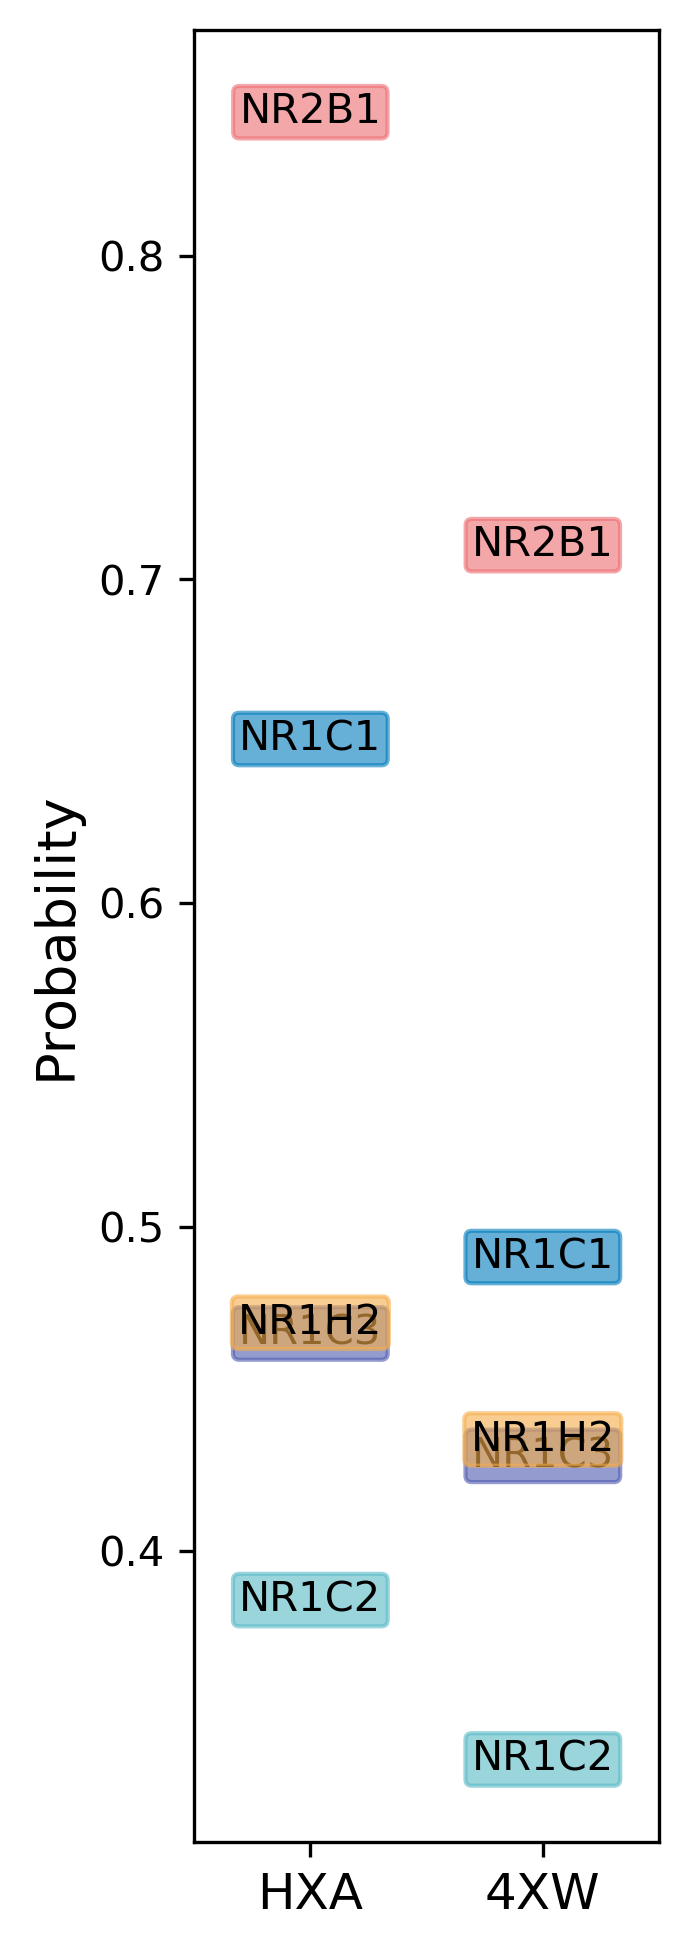

In [5]:
_ = plt.figure(1, (2, 8), dpi=300)

colors = {'NR1C1':'#007bbb', 'NR1C2':'#59b9c6', 'NR1C3':'#4d5aaf', 'NR1H2':'#f6ad49', 'NR2B1':'#ec6d71'}

l = 'HXA'
values = [probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values for p in Pro_in_model]
_ = plt.scatter([0 for i in range(len(values))], values, s=0)

for p in Pro_in_model:
    value = probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values
    bbox_props = dict(boxstyle=BoxStyle('round', pad=0.15), fc=colors[p], ec=colors[p], lw=1, alpha=0.6)
    _ = plt.text(0, value, p, ha="center", va="center", rotation=0, size=10, bbox=bbox_props, zorder=15)

l = '4XW'
values = [probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values for p in Pro_in_model]
_ = plt.scatter([1 for i in range(len(values))], values, s=0)

for p in Pro_in_model:
    value = probs.loc[(probs['ID']==l)&(probs['PID']==p), 'Prob'].values
    bbox_props = dict(boxstyle=BoxStyle('round', pad=0.15), fc=colors[p], ec=colors[p], lw=1, alpha=0.6)
    _ = plt.text(1, value, p, ha="center", va="center", rotation=0, size=10, bbox=bbox_props, zorder=15)

_ = plt.xlim(-0.5, 1.5)
#_ = plt.ylim(0.5, 0.83)
_ = plt.xticks([0, 1], ['HXA', '4XW'], fontsize=12)
_ = plt.ylabel('Probability', fontsize=13)
_ = plt.show()

In [6]:
approved_drug_probs = pd.read_csv('DB_result/approved_drug_prob.csv', index_col=0)
approved_drug_probs['Prob'] = 1-approved_drug_probs['Prob']
approved_drug_probs.head(2)
chembl_random_probs = pd.read_csv('DB_result/chembl_random_prob.csv', index_col=0)
chembl_random_probs['Prob'] = 1-chembl_random_probs['Prob']
chembl_random_probs.head(2)
experimental_drug_probs = pd.read_csv('DB_result/experimental_drug_prob.csv', index_col=0)
experimental_drug_probs['Prob'] = 1-experimental_drug_probs['Prob']
experimental_drug_probs.head(2)
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs.head(2)

,PID,ID,NAME,Prob
0,NR1C1,DB00006,Bivalirudin,0.502096
1,NR1C2,DB00006,Bivalirudin,0.445110


,PID,ID,NAME,Prob
0,NR1C1,CHEMBL1783156,CHEMBL1783156,0.293413
1,NR1C2,CHEMBL1783156,CHEMBL1783156,0.285429


,PID,ID,NAME,Prob
0,NR1C1,DB00466,Picrotoxin,0.466068
1,NR1C2,DB00466,Picrotoxin,0.452096


,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.403992
1,NR1C2,ZINC85532298,ZINC85532298,0.333999


In [7]:
approved_drug_probs = pd.read_csv('DB_result/approved_drug_prob.csv', index_col=0)
approved_drug_probs['Prob'] = 1-approved_drug_probs['Prob']
approved_drug_probs.head(2)
chembl_random_probs = pd.read_csv('DB_result/chembl_random_prob.csv', index_col=0)
chembl_random_probs['Prob'] = 1-chembl_random_probs['Prob']
chembl_random_probs.head(2)
experimental_drug_probs = pd.read_csv('DB_result/experimental_drug_prob.csv', index_col=0)
experimental_drug_probs['Prob'] = 1-experimental_drug_probs['Prob']
experimental_drug_probs.head(2)
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs.head(2)

ligand_res5 = []
ligand_res7 = []
for p in Pro_in_DB:
    row5 = []
    row7 = []
    for res in [approved_drug_probs, experimental_drug_probs, chembl_random_probs,TCM_Taiwan_probs]:
        values = res.loc[res['PID']==p, 'Prob'].values
        p, len(values), (values>=0.7).sum(), (values>=0.7).sum()/float(len(values))
        row5.append((values>=0.5).sum()/float(len(values)))
        row7.append((values>=0.7).sum()/float(len(values)))
    ligand_res5.append(row5)
    ligand_res7.append(row7)
ligand_res5 = pd.DataFrame(ligand_res5, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
ligand_res5
ligand_res7 = pd.DataFrame(ligand_res7, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
ligand_res7

,PID,ID,NAME,Prob
0,NR1C1,DB00006,Bivalirudin,0.502096
1,NR1C2,DB00006,Bivalirudin,0.445110


,PID,ID,NAME,Prob
0,NR1C1,CHEMBL1783156,CHEMBL1783156,0.293413
1,NR1C2,CHEMBL1783156,CHEMBL1783156,0.285429


,PID,ID,NAME,Prob
0,NR1C1,DB00466,Picrotoxin,0.466068
1,NR1C2,DB00466,Picrotoxin,0.452096


,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.403992
1,NR1C2,ZINC85532298,ZINC85532298,0.333999


('NR1C1', 2045, 0, 0.0)

('NR1C1', 5135, 8, 0.001557935735150925)

('NR1C1', 5000, 2, 0.0004)

('NR1C1', 6767, 0, 0.0)

('NR1C2', 2045, 0, 0.0)

('NR1C2', 5135, 5, 0.0009737098344693282)

('NR1C2', 5000, 3, 0.0006)

('NR1C2', 6767, 0, 0.0)

('NR1C3', 2045, 0, 0.0)

('NR1C3', 5135, 4, 0.0007789678675754625)

('NR1C3', 5000, 6, 0.0012)

('NR1C3', 6767, 0, 0.0)

('NR1H2', 2045, 0, 0.0)

('NR1H2', 5135, 2, 0.00038948393378773126)

('NR1H2', 5000, 3, 0.0006)

('NR1H2', 6767, 0, 0.0)

('NR2B1', 2045, 34, 0.016625916870415647)

('NR2B1', 5135, 38, 0.007400194741966894)

('NR2B1', 5000, 85, 0.017)

('NR2B1', 6767, 65, 0.009605438155755874)

('NR1H3', 2045, 1, 0.0004889975550122249)

('NR1H3', 5135, 2, 0.00038948393378773126)

('NR1H3', 5000, 2, 0.0004)

('NR1H3', 6767, 2, 0.0002955519432540269)

('NR1H4', 2045, 0, 0.0)

('NR1H4', 5135, 2, 0.00038948393378773126)

('NR1H4', 5000, 2, 0.0004)

('NR1H4', 6767, 0, 0.0)

('NR2B3', 2045, 42, 0.020537897310513448)

('NR2B3', 5135, 46, 0.008958130477117819)

('NR2B3', 5000, 98, 0.0196)

('NR2B3', 6767, 117, 0.017289788680360574)

('NR2B2', 2045, 21, 0.010268948655256724)

('NR2B2', 5135, 18, 0.003505355404089581)

('NR2B2', 5000, 40, 0.008)

('NR2B2', 6767, 46, 0.006797694694842618)

('NR1D1', 2045, 121, 0.05916870415647922)

('NR1D1', 5135, 191, 0.03719571567672834)

('NR1D1', 5000, 544, 0.1088)

('NR1D1', 6767, 302, 0.04462834343135806)

('NR1I2', 2045, 114, 0.05574572127139364)

('NR1I2', 5135, 156, 0.030379746835443037)

('NR1I2', 5000, 470, 0.094)

('NR1I2', 6767, 374, 0.05526821338850303)

,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.062592,0.041091,0.1326,0.297769
NR1C2,0.029829,0.022785,0.0728,0.170681
NR1C3,0.124205,0.081597,0.2734,0.568051
NR1H2,0.093888,0.068160,0.1846,0.272942
NR2B1,0.286553,0.263486,0.4148,0.475395
NR1H3,0.065037,0.033106,0.1136,0.315649
NR1H4,0.047922,0.024537,0.0814,0.225358
NR2B3,0.302689,0.251801,0.4210,0.707108
NR2B2,0.196577,0.171178,0.2676,0.259199
NR1D1,0.437164,0.370204,0.6482,0.935570


,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.000000,0.001558,0.0004,0.000000
NR1C2,0.000000,0.000974,0.0006,0.000000
NR1C3,0.000000,0.000779,0.0012,0.000000
NR1H2,0.000000,0.000389,0.0006,0.000000
NR2B1,0.016626,0.007400,0.0170,0.009605
NR1H3,0.000489,0.000389,0.0004,0.000296
NR1H4,0.000000,0.000389,0.0004,0.000000
NR2B3,0.020538,0.008958,0.0196,0.017290
NR2B2,0.010269,0.003505,0.0080,0.006798
NR1D1,0.059169,0.037196,0.1088,0.044628


In [8]:
approved_drug_probs = pd.read_csv('DB_result/approved_drug_scaffold_prob.csv', index_col=0)
approved_drug_probs['Prob'] = 1-approved_drug_probs['Prob']
approved_drug_probs.head(2)
chembl_random_probs = pd.read_csv('DB_result/chembl_random_scaffold_prob.csv', index_col=0)
chembl_random_probs['Prob'] = 1-chembl_random_probs['Prob']
chembl_random_probs.head(2)
experimental_drug_probs = pd.read_csv('DB_result/experimental_drug_scaffold_prob.csv', index_col=0)
experimental_drug_probs['Prob'] = 1-experimental_drug_probs['Prob']
experimental_drug_probs.head(2)
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_scaffold_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs.head(2)

scaffold_res5 = []
scaffold_res7 = []
for p in Pro_in_DB:
    row5 = []
    row7 = []
    for res in [approved_drug_probs, experimental_drug_probs, chembl_random_probs,TCM_Taiwan_probs]:
        values = res.loc[res['PID']==p, 'Prob'].values
        p, len(values), (values>=0.7).sum(), (values>=0.7).sum()/float(len(values))
        row5.append((values>=0.5).sum()/float(len(values)))
        row7.append((values>=0.7).sum()/float(len(values)))
    scaffold_res5.append(row5)
    scaffold_res7.append(row7)
scaffold_res5 = pd.DataFrame(scaffold_res5, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
scaffold_res5
scaffold_res7 = pd.DataFrame(scaffold_res7, columns=['Approved', 'Experimental', 'ChEMBL', 'TCM@Taiwan'], index=Pro_in_DB)
scaffold_res7

,PID,ID,NAME,Prob
0,NR1C1,DB00006,Bivalirudin,0.464338
1,NR1C2,DB00006,Bivalirudin,0.394877


,PID,ID,NAME,Prob
0,NR1C1,CHEMBL1783156,CHEMBL1783156,0.344454
1,NR1C2,CHEMBL1783156,CHEMBL1783156,0.308383


,PID,ID,NAME,Prob
0,NR1C1,DB00466,Picrotoxin,0.418164
1,NR1C2,DB00466,Picrotoxin,0.398536


,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.408383
1,NR1C2,ZINC85532298,ZINC85532298,0.314457


('NR1C1', 1716, 0, 0.0)

('NR1C1', 4330, 0, 0.0)

('NR1C1', 4940, 0, 0.0)

('NR1C1', 6725, 0, 0.0)

('NR1C2', 1716, 0, 0.0)

('NR1C2', 4330, 0, 0.0)

('NR1C2', 4940, 0, 0.0)

('NR1C2', 6725, 0, 0.0)

('NR1C3', 1716, 0, 0.0)

('NR1C3', 4330, 0, 0.0)

('NR1C3', 4940, 0, 0.0)

('NR1C3', 6725, 0, 0.0)

('NR1H2', 1716, 0, 0.0)

('NR1H2', 4330, 0, 0.0)

('NR1H2', 4940, 0, 0.0)

('NR1H2', 6725, 0, 0.0)

('NR2B1', 1716, 21, 0.012237762237762238)

('NR2B1', 4330, 37, 0.008545034642032332)

('NR2B1', 4940, 65, 0.013157894736842105)

('NR2B1', 6725, 337, 0.050111524163568774)

('NR1H3', 1716, 0, 0.0)

('NR1H3', 4330, 0, 0.0)

('NR1H3', 4940, 1, 0.00020242914979757084)

('NR1H3', 6725, 0, 0.0)

('NR1H4', 1716, 0, 0.0)

('NR1H4', 4330, 0, 0.0)

('NR1H4', 4940, 0, 0.0)

('NR1H4', 6725, 0, 0.0)

('NR2B3', 1716, 22, 0.01282051282051282)

('NR2B3', 4330, 37, 0.008545034642032332)

('NR2B3', 4940, 70, 0.01417004048582996)

('NR2B3', 6725, 427, 0.06349442379182156)

('NR2B2', 1716, 13, 0.007575757575757576)

('NR2B2', 4330, 23, 0.005311778290993071)

('NR2B2', 4940, 37, 0.007489878542510121)

('NR2B2', 6725, 228, 0.033903345724907066)

('NR1D1', 1716, 59, 0.034382284382284384)

('NR1D1', 4330, 119, 0.02748267898383372)

('NR1D1', 4940, 291, 0.05890688259109312)

('NR1D1', 6725, 1361, 0.20237918215613382)

('NR1I2', 1716, 65, 0.03787878787878788)

('NR1I2', 4330, 107, 0.024711316397228636)

('NR1I2', 4940, 287, 0.05809716599190284)

('NR1I2', 6725, 1644, 0.24446096654275093)

,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.023310,0.013857,0.032794,0.118513
NR1C2,0.011072,0.007390,0.016397,0.054721
NR1C3,0.069930,0.050115,0.109312,0.277472
NR1H2,0.037879,0.022633,0.047571,0.073011
NR2B1,0.109557,0.088915,0.177328,0.488476
NR1H3,0.044872,0.022171,0.041498,0.205353
NR1H4,0.021562,0.006697,0.015992,0.058439
NR2B3,0.111888,0.087991,0.180972,0.553755
NR2B2,0.076923,0.059584,0.118623,0.452045
NR1D1,0.203380,0.162125,0.331579,0.665130


,Approved,Experimental,ChEMBL,TCM@Taiwan
NR1C1,0.000000,0.000000,0.000000,0.000000
NR1C2,0.000000,0.000000,0.000000,0.000000
NR1C3,0.000000,0.000000,0.000000,0.000000
NR1H2,0.000000,0.000000,0.000000,0.000000
NR2B1,0.012238,0.008545,0.013158,0.050112
NR1H3,0.000000,0.000000,0.000202,0.000000
NR1H4,0.000000,0.000000,0.000000,0.000000
NR2B3,0.012821,0.008545,0.014170,0.063494
NR2B2,0.007576,0.005312,0.007490,0.033903
NR1D1,0.034382,0.027483,0.058907,0.202379


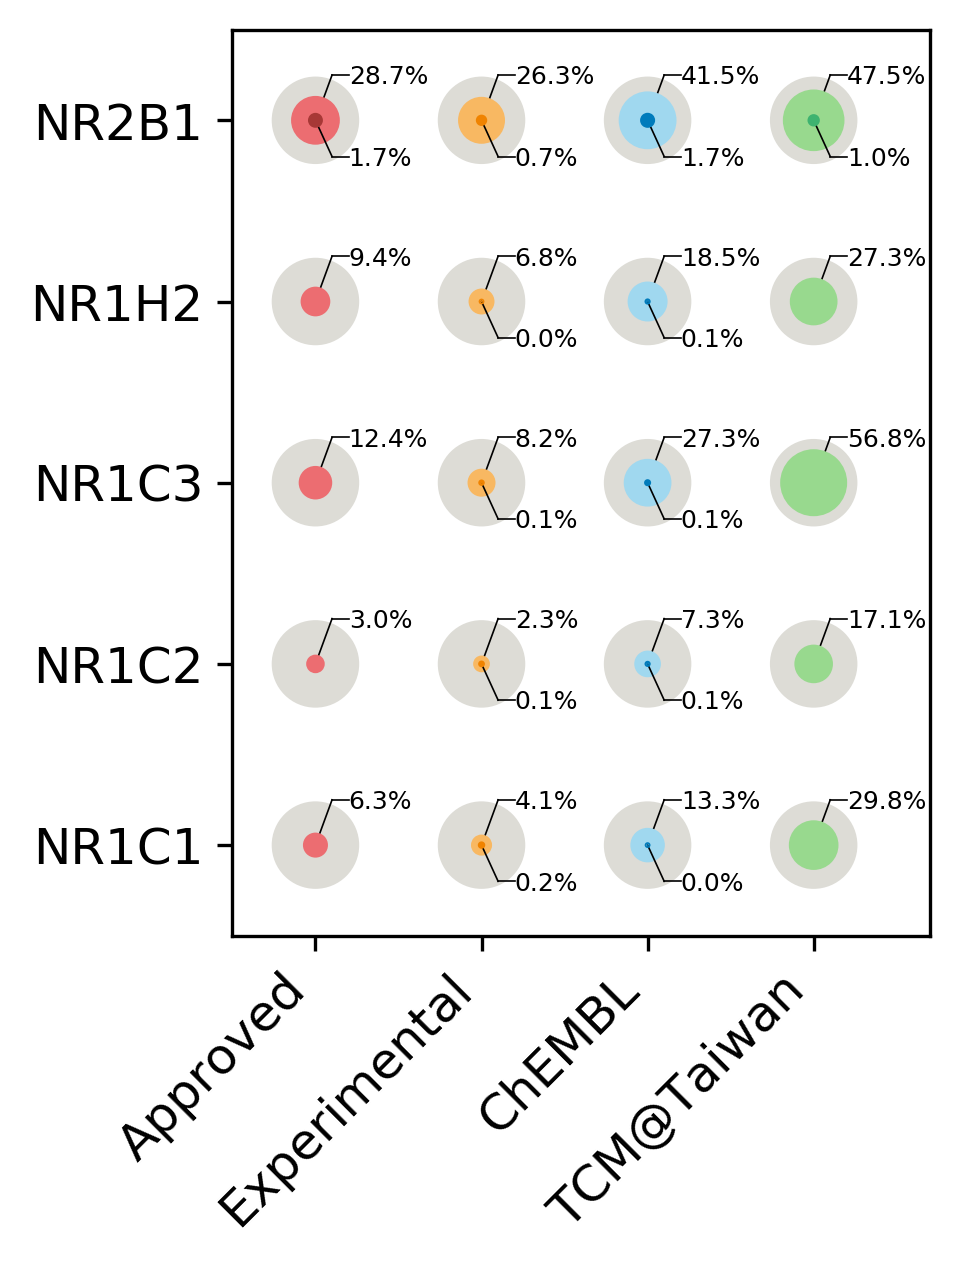

In [9]:
ligand_res5 = ligand_res5.loc[Pro_in_model, :]
ligand_res7 = ligand_res7.loc[Pro_in_model, :]

colors5 = ['#ec6d71', '#f8b862', '#a0d8ef', '#98d98e']
colors7 = ['#a73836', '#f08300', '#007bbb', '#3eb370']
color_map5 = []
plot_data5 = []
for i in range(ligand_res5.shape[1]):
    for j in range(ligand_res5.shape[0]):
        plot_data5.append([i, j, ligand_res5.iloc[j, i], 1.0])
        color_map5.append(colors5[i])
plot_data5 = np.array(plot_data5)

plot_data7 = []
color_map7 = []
for i in range(ligand_res7.shape[1]):
    for j in range(ligand_res7.shape[0]):
        plot_data7.append([i, j, ligand_res7.iloc[j, i], 1.0])
        color_map7.append(colors7[i])
plot_data7 = np.array(plot_data7)

_ = plt.figure(1, (3, 4), dpi=300)
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 3]*400, zorder=0, color='#dddcd6')
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 2]*400, zorder=10, color=color_map5)
_ = plt.scatter(plot_data7[:, 0], plot_data7[:, 1], s=plot_data7[:, 2]*400, zorder=15, color=color_map7)
for l in range(len(plot_data5)):
    i = plot_data5[l, 0]
    j = plot_data5[l, 1]
    v1 = plot_data5[l, 2]
    value1 = "{:.1f}%".format(v1*100)
    v2 = plot_data7[l, 2]
    value2 = "{:.1f}%".format(v2*100)
    if v1!=0:
        _ = plt.annotate(value1, xy=(i+0.2, j+0.2), zorder=18, fontsize=6)
        _ = plt.plot([i+0.2, i+0.1], [j+0.25, j+0.25], c='k', lw=0.4, zorder=8)
        _ = plt.plot([i+0.0, i+0.1], [j+0.0, j+0.25], c='k', lw=0.4, zorder=8)
    if v2!=0:
        _ = plt.annotate(value2, xy=(i+0.2, j-0.25), zorder=18, fontsize=6)
        _ = plt.plot([i+0.2, i+0.1], [j-0.2, j-0.2], c='k', lw=0.4, zorder=12)
        _ = plt.plot([i+0.0, i+0.1], [j+0.0, j-0.2], c='k', lw=0.4, zorder=12)
        
_ = plt.yticks(range(ligand_res5.shape[0]), list(ligand_res5.index), fontsize=12)
_ = plt.xticks([0, 1, 2, 3], list(ligand_res5.columns), rotation=45, ha='right', fontsize=12)
_ = plt.xlim(-0.5, 3.7)
_ = plt.ylim(-0.5, 4.5)
_ = plt.show()

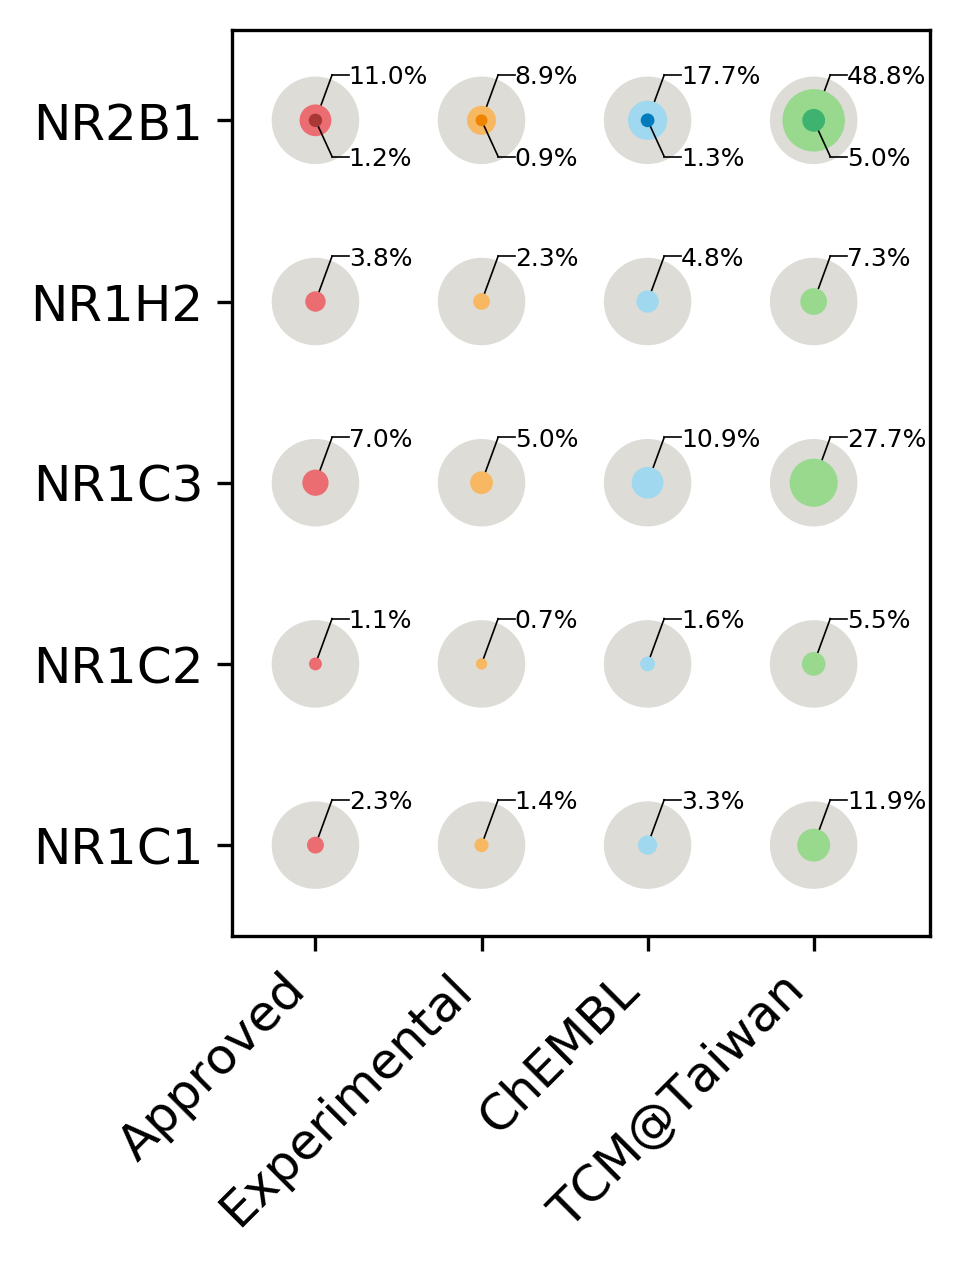

In [10]:
scaffold_res5 = scaffold_res5.loc[Pro_in_model, :]
scaffold_res7 = scaffold_res7.loc[Pro_in_model, :]

colors5 = ['#ec6d71', '#f8b862', '#a0d8ef', '#98d98e']
colors7 = ['#a73836', '#f08300', '#007bbb', '#3eb370']
color_map5 = []
plot_data5 = []
for i in range(scaffold_res5.shape[1]):
    for j in range(scaffold_res5.shape[0]):
        plot_data5.append([i, j, scaffold_res5.iloc[j, i], 1.0])
        color_map5.append(colors5[i])
plot_data5 = np.array(plot_data5)

plot_data7 = []
color_map7 = []
for i in range(scaffold_res7.shape[1]):
    for j in range(scaffold_res7.shape[0]):
        plot_data7.append([i, j, scaffold_res7.iloc[j, i], 1.0])
        color_map7.append(colors7[i])
plot_data7 = np.array(plot_data7)

_ = plt.figure(1, (3, 4), dpi=300)
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 3]*400, zorder=0, color='#dddcd6')
_ = plt.scatter(plot_data5[:, 0], plot_data5[:, 1], s=plot_data5[:, 2]*400, zorder=10, color=color_map5)
_ = plt.scatter(plot_data7[:, 0], plot_data7[:, 1], s=plot_data7[:, 2]*400, zorder=15, color=color_map7)
for l in range(len(plot_data5)):
    i = plot_data5[l, 0]
    j = plot_data5[l, 1]
    v1 = plot_data5[l, 2]
    value1 = "{:.1f}%".format(v1*100)
    v2 = plot_data7[l, 2]
    value2 = "{:.1f}%".format(v2*100)
    if v1!=0:
        _ = plt.annotate(value1, xy=(i+0.2, j+0.2), zorder=18, fontsize=6)
        _ = plt.plot([i+0.2, i+0.1], [j+0.25, j+0.25], c='k', lw=0.4, zorder=8)
        _ = plt.plot([i+0.0, i+0.1], [j+0.0, j+0.25], c='k', lw=0.4, zorder=8)
    if v2!=0:
        _ = plt.annotate(value2, xy=(i+0.2, j-0.25), zorder=18, fontsize=6)
        _ = plt.plot([i+0.2, i+0.1], [j-0.2, j-0.2], c='k', lw=0.4, zorder=12)
        _ = plt.plot([i+0.0, i+0.1], [j+0.0, j-0.2], c='k', lw=0.4, zorder=12)

_ = plt.yticks(range(scaffold_res5.shape[0]), list(scaffold_res5.index), fontsize=12)
_ = plt.xticks([0, 1, 2, 3], list(scaffold_res5.columns), rotation=45, ha='right', fontsize=12)
_ = plt.xlim(-0.5, 3.7)
_ = plt.ylim(-0.5, 4.5)
_ = plt.show()

# Predition result of TCM taiwan

In [11]:
TCM_Taiwan_probs = pd.read_csv('DB_result/TCM_Taiwan_prob.csv', index_col=0)
TCM_Taiwan_probs['Prob'] = 1-TCM_Taiwan_probs['Prob']
TCM_Taiwan_probs

,PID,ID,NAME,Prob
0,NR1C1,ZINC85532298,ZINC85532298,0.403992
1,NR1C2,ZINC85532298,ZINC85532298,0.333999
2,NR1C3,ZINC85532298,ZINC85532298,0.394877
3,NR1H2,ZINC85532298,ZINC85532298,0.365935
4,NR2B1,ZINC85532298,ZINC85532298,0.514970
...,...,...,...,...
74432,NR1H4,ZINC70455164,ZINC70455164,0.463573
74433,NR2B3,ZINC70455164,ZINC70455164,0.554890
74434,NR2B2,ZINC70455164,ZINC70455164,0.524950
74435,NR1D1,ZINC70455164,ZINC70455164,0.588822


In [ ]:
result = []
for CID in set(TCM_Taiwan_probs['ID']):
    row = [CID]
    topprob = 0.0
    toptarget = ''
    for PID in ['NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1']:
        prob = TCM_Taiwan_probs.loc[(TCM_Taiwan_probs['ID']==CID)&(TCM_Taiwan_probs['PID']==PID), 'Prob'].values[0]
        if prob>=topprob:
            topprob = prob
            toptarget = PID
        row.append(prob)
    row.append(max(row[1:]))
    row.append(toptarget)
    len(set(TCM_Taiwan_probs['ID'])), len(result), row
    result.append(row)
result = pd.DataFrame(result, columns=['CID', 'NR1C1', 'NR1C2', 'NR1C3', 'NR1H2', 'NR2B1', 'MaxProb', 'TopTarget'])
result

(6767,
 0,
 ['ZINC14828692',
  0.43193612774451096,
  0.3792415169660679,
  0.48103792415169666,
  0.3872255489021956,
  0.40718562874251496,
  0.48103792415169666,
  'NR1C3'])

(6767,
 1,
 ['ZINC85567154',
  0.494544244843646,
  0.437125748502994,
  0.5069860279441119,
  0.499001996007984,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 2,
 ['ZINC95919087',
  0.4890219560878244,
  0.4278110445775116,
  0.44677312042581496,
  0.4619095143047238,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 3,
 ['ZINC13379151',
  0.47234103222127166,
  0.4401197604790419,
  0.5192947438456421,
  0.4683965402528276,
  0.4730538922155688,
  0.5192947438456421,
  'NR1C3'])

(6767,
 4,
 ['ZINC04098505',
  0.47571523619427813,
  0.503992015968064,
  0.5389221556886227,
  0.4870259481037924,
  0.530938123752495,
  0.5389221556886227,
  'NR1C3'])

(6767,
 5,
 ['ZINC85547803',
  0.3950432468396541,
  0.27079174983366594,
  0.33632734530938124,
  0.35395874916833003,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 6,
 ['ZINC85596865',
  0.49724360802205103,
  0.3865602129075182,
  0.4900199600798403,
  0.4247219846022241,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 7,
 ['ZINC70454051',
  0.5893213572854291,
  0.5748502994011976,
  0.6686626746506986,
  0.594810379241517,
  0.5369261477045908,
  0.6686626746506986,
  'NR1C3'])

(6767,
 8,
 ['ZINC85542034',
  0.5646373918829009,
  0.562874251497006,
  0.5998003992015968,
  0.5668662674650699,
  0.5249500998003992,
  0.5998003992015968,
  'NR1C3'])

(6767,
 9,
 ['ZINC85532517',
  0.4678753603903305,
  0.45825016633399873,
  0.5276114437791085,
  0.47671324018629413,
  0.6057884231536926,
  0.6057884231536926,
  'NR2B1'])

(6767,
 10,
 ['ZINC05857566',
  0.43133732534930147,
  0.33752495009980044,
  0.3593147039254825,
  0.3967065868263473,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 11,
 ['ZINC85541830',
  0.5370497101036025,
  0.5429141716566865,
  0.6007984031936128,
  0.5469061876247505,
  0.5249500998003992,
  0.6007984031936128,
  'NR1C3'])

(6767,
 12,
 ['ZINC85545388',
  0.505189620758483,
  0.4610778443113772,
  0.5394211576846307,
  0.4750499001996008,
  0.47904191616766467,
  0.5394211576846307,
  'NR1C3'])

(6767,
 13,
 ['ZINC85594062',
  0.43572854291417173,
  0.38522954091816364,
  0.4863606121091152,
  0.4011976047904192,
  0.4770459081836327,
  0.4863606121091152,
  'NR1C3'])

(6767,
 14,
 ['ZINC85645902',
  0.6045484787999758,
  0.592814371257485,
  0.6327345309381238,
  0.652694610778443,
  0.5116433799068529,
  0.652694610778443,
  'NR1H2'])

(6767,
 15,
 ['ZINC44351784',
  0.5548902195608783,
  0.5129740518962076,
  0.6367265469061876,
  0.5548902195608783,
  0.5389221556886227,
  0.6367265469061876,
  'NR1C3'])

(6767,
 16,
 ['ZINC85566539',
  0.5182967398536261,
  0.5209580838323353,
  0.5832620473339036,
  0.5429141716566865,
  0.5349301397205589,
  0.5832620473339036,
  'NR1C3'])

(6767,
 17,
 ['ZINC14618654',
  0.5140005702879954,
  0.4886227544910179,
  0.5566533599467731,
  0.48263473053892214,
  0.4850299401197605,
  0.5566533599467731,
  'NR1C3'])

(6767,
 18,
 ['ZINC13459338',
  0.48120425815036605,
  0.49750499001996007,
  0.5370592149035263,
  0.5651696606786427,
  0.45508982035928147,
  0.5651696606786427,
  'NR1H2'])

(6767,
 19,
 ['ZINC59773522',
  0.5059880239520957,
  0.47205588822355293,
  0.56187624750499,
  0.5159680638722555,
  0.5189620758483033,
  0.56187624750499,
  'NR1C3'])

(6767,
 20,
 ['ZINC85595800',
  0.5113344739093242,
  0.499001996007984,
  0.562874251497006,
  0.5429141716566865,
  0.4271457085828343,
  0.562874251497006,
  'NR1C3'])

(6767,
 21,
 ['ZINC49833390',
  0.5172987358616101,
  0.5216234198270127,
  0.5695276114437791,
  0.5262807717897537,
  0.5508982035928144,
  0.5695276114437791,
  'NR1C3'])

(6767,
 22,
 ['ZINC85625595',
  0.37125748502994016,
  0.37225548902195604,
  0.44311377245508987,
  0.3772455089820359,
  0.4510978043912176,
  0.4510978043912176,
  'NR2B1'])

(6767,
 23,
 ['ZINC85626197',
  0.48450717612394256,
  0.4411177644710579,
  0.5389221556886227,
  0.48303393213572854,
  0.40452428476380564,
  0.5389221556886227,
  'NR1C3'])

(6767,
 24,
 ['ZINC85570954',
  0.4786427145708583,
  0.47904191616766467,
  0.560878243512974,
  0.4673652694610778,
  0.47904191616766467,
  0.560878243512974,
  'NR1C3'])

(6767,
 25,
 ['ZINC85596450',
  0.48003992015968067,
  0.41017964071856283,
  0.5404191616766467,
  0.4970059880239521,
  0.4610778443113772,
  0.5404191616766467,
  'NR1C3'])

(6767,
 26,
 ['ZINC85629521',
  0.5324018629407852,
  0.4151696606786427,
  0.5439121756487026,
  0.4770459081836327,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 27,
 ['ZINC00897912',
  0.4990305104077559,
  0.4750499001996008,
  0.5342648037258816,
  0.47005988023952094,
  0.5129740518962076,
  0.5342648037258816,
  'NR1C3'])

(6767,
 28,
 ['ZINC85596001',
  0.40232867598137056,
  0.38622754491017963,
  0.5429141716566865,
  0.4667332002661344,
  0.39321357285429137,
  0.5429141716566865,
  'NR1C3'])

(6767,
 29,
 ['ZINC85632747',
  0.4594699489909071,
  0.498003992015968,
  0.48769128409846985,
  0.45708582834331335,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 30,
 ['ZINC85592397',
  0.4864049678420935,
  0.4407185628742515,
  0.4984198270126413,
  0.5016633399866933,
  0.435129740518962,
  0.5016633399866933,
  'NR1H2'])

(6767,
 31,
 ['ZINC85592565',
  0.44434939644520477,
  0.4367265469061876,
  0.5035928143712576,
  0.44145043246839644,
  0.4870259481037924,
  0.5035928143712576,
  'NR1C3'])

(6767,
 32,
 ['ZINC85593863',
  0.4609891328454203,
  0.4970059880239521,
  0.5069860279441119,
  0.5129740518962076,
  0.4850299401197605,
  0.5129740518962076,
  'NR1H2'])

(6767,
 33,
 ['ZINC85570747',
  0.4171656686626747,
  0.33333333333333337,
  0.44311377245508987,
  0.4011976047904192,
  0.48303393213572854,
  0.48303393213572854,
  'NR2B1'])

(6767,
 34,
 ['ZINC85595840',
  0.48343313373253494,
  0.4271457085828343,
  0.5029940119760479,
  0.47438456420492336,
  0.44510978043912175,
  0.5029940119760479,
  'NR1C3'])

(6767,
 35,
 ['ZINC85568645',
  0.43579507651363936,
  0.437125748502994,
  0.499001996007984,
  0.4697272122421823,
  0.4500998003992016,
  0.499001996007984,
  'NR1C3'])

(6767,
 36,
 ['ZINC85596243',
  0.4740518962075848,
  0.4206586826347305,
  0.4585828343313373,
  0.4870259481037924,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 37,
 ['ZINC85630335',
  0.43812375249501,
  0.39720558882235524,
  0.47904191616766467,
  0.437125748502994,
  0.41916167664670656,
  0.47904191616766467,
  'NR1C3'])

(6767,
 38,
 ['ZINC95910422',
  0.5136869118905047,
  0.4173652694610779,
  0.45076513639387883,
  0.49500998003992014,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 39,
 ['ZINC95909812',
  0.4860279441117764,
  0.4870259481037924,
  0.5548902195608783,
  0.532934131736527,
  0.4970059880239521,
  0.5548902195608783,
  'NR1C3'])

(6767,
 40,
 ['ZINC85542215',
  0.5324683965402528,
  0.5169660678642716,
  0.5598802395209581,
  0.5029940119760479,
  0.5449101796407185,
  0.5598802395209581,
  'NR1C3'])

(6767,
 41,
 ['ZINC85532241',
  0.4742182302062542,
  0.4467731204258151,
  0.5469061876247505,
  0.42581503659347963,
  0.5169660678642716,
  0.5469061876247505,
  'NR1C3'])

(6767,
 42,
 ['ZINC34587726',
  0.437125748502994,
  0.38423153692614775,
  0.44411177644710575,
  0.4106786427145709,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 43,
 ['ZINC85594662',
  0.44048569527611436,
  0.3958749168330007,
  0.4467731204258151,
  0.4770459081836327,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 44,
 ['ZINC85597502',
  0.4683965402528276,
  0.48103792415169666,
  0.5056553559547571,
  0.47105788423153694,
  0.4630738522954092,
  0.5056553559547571,
  'NR1C3'])

(6767,
 45,
 ['ZINC85540194',
  0.46293128029654984,
  0.46906187624750506,
  0.5169660678642716,
  0.4730538922155688,
  0.45908183632734534,
  0.5169660678642716,
  'NR1C3'])

(6767,
 46,
 ['ZINC85597446',
  0.4910417260716662,
  0.4021956087824351,
  0.5499001996007984,
  0.4786427145708583,
  0.40252827677977376,
  0.5499001996007984,
  'NR1C3'])

(6767,
 47,
 ['ZINC85531092',
  0.4647371922821024,
  0.49201596806387227,
  0.5578842315369261,
  0.5206254158349968,
  0.44710578842315374,
  0.5578842315369261,
  'NR1C3'])

(6767,
 48,
 ['ZINC85542738',
  0.4693280106453759,
  0.40818363273453107,
  0.5074850299401198,
  0.44693945442448424,
  0.5159680638722555,
  0.5159680638722555,
  'NR2B1'])

(6767,
 49,
 ['ZINC85570579',
  0.4951430472388557,
  0.4890219560878244,
  0.5469061876247505,
  0.48203592814371254,
  0.47205588822355293,
  0.5469061876247505,
  'NR1C3'])

(6767,
 50,
 ['ZINC59587789',
  0.3932848588537212,
  0.3719228210246175,
  0.38722554890219574,
  0.39906852960745176,
  0.47272122421823026,
  0.47272122421823026,
  'NR2B1'])

(6767,
 51,
 ['ZINC85549384',
  0.4936840604505275,
  0.45668662674650706,
  0.5285429141716567,
  0.4277445109780439,
  0.49301397205588826,
  0.5285429141716567,
  'NR1C3'])

(6767,
 52,
 ['ZINC85592630',
  0.5003326679973388,
  0.43313373253493015,
  0.5342648037258815,
  0.5139720558882235,
  0.4108449767132403,
  0.5342648037258815,
  'NR1C3'])

(6767,
 53,
 ['ZINC85592673',
  0.49101796407185627,
  0.45508982035928147,
  0.5399201596806387,
  0.5469061876247505,
  0.47205588822355293,
  0.5469061876247505,
  'NR1H2'])

(6767,
 54,
 ['ZINC14690613',
  0.4491017964071856,
  0.5,
  0.49750499001996007,
  0.436127744510978,
  0.44710578842315374,
  0.5,
  'NR1C2'])

(6767,
 55,
 ['ZINC85549381',
  0.5035642999714856,
  0.43313373253493015,
  0.5269461077844311,
  0.4421157684630739,
  0.48303393213572854,
  0.5269461077844311,
  'NR1C3'])

(6767,
 56,
 ['ZINC85508607',
  0.4366741264944858,
  0.3672352265166636,
  0.4219258452791387,
  0.402605899312486,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 57,
 ['ZINC95099405',
  0.4399201596806387,
  0.3642714570858283,
  0.45708582834331335,
  0.3782435129740519,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 58,
 ['ZINC13378016',
  0.4850299401197605,
  0.4401197604790419,
  0.5054890219560878,
  0.44610778443113774,
  0.49301397205588826,
  0.5054890219560878,
  'NR1C3'])

(6767,
 59,
 ['ZINC45351077',
  0.5351828089852043,
  0.614105123087159,
  0.5740384310743591,
  0.5346307385229541,
  0.5728542914171656,
  0.614105123087159,
  'NR1C2'])

(6767,
 60,
 ['ZINC85629336',
  0.4391217564870259,
  0.437125748502994,
  0.4650698602794411,
  0.43113772455089816,
  0.45908183632734534,
  0.4650698602794411,
  'NR1C3'])

(6767,
 61,
 ['ZINC85592600',
  0.4649035262807717,
  0.44510978043912175,
  0.5209580838323353,
  0.46806387225548907,
  0.5189620758483033,
  0.5209580838323353,
  'NR1C3'])

(6767,
 62,
 ['ZINC85624542',
  0.5066533599467731,
  0.4547571523619427,
  0.5375914836992681,
  0.49767132401862935,
  0.47904191616766467,
  0.5375914836992681,
  'NR1C3'])

(6767,
 63,
 ['ZINC85531234',
  0.5047591685316236,
  0.5199600798403192,
  0.5523952095808383,
  0.5437458416500334,
  0.4750499001996008,
  0.5523952095808383,
  'NR1C3'])

(6767,
 64,
 ['ZINC05158749',
  0.45508982035928147,
  0.4900199600798403,
  0.4870259481037924,
  0.4416167664670658,
  0.4546906187624751,
  0.4900199600798403,
  'NR1C2'])

(6767,
 65,
 ['ZINC85592321',
  0.5375914836992681,
  0.5029940119760479,
  0.5449101796407185,
  0.5449101796407185,
  0.437125748502994,
  0.5449101796407185,
  'NR1H2'])

(6767,
 66,
 ['ZINC85595477',
  0.5118164824751651,
  0.42215568862275454,
  0.5506986027944112,
  0.4998003992015968,
  0.4630738522954092,
  0.5506986027944112,
  'NR1C3'])

(6767,
 67,
 ['ZINC14884125',
  0.4845309381237525,
  0.4833666001330671,
  0.5351860381800502,
  0.45708582834331335,
  0.6493679308050566,
  0.6493679308050566,
  'NR2B1'])

(6767,
 68,
 ['ZINC85630704',
  0.5193612774451097,
  0.4870259481037924,
  0.5588822355289421,
  0.5099800399201597,
  0.4730538922155688,
  0.5588822355289421,
  'NR1C3'])

(6767,
 69,
 ['ZINC85631240',
  0.4272470931153566,
  0.35728542914171646,
  0.45176314038589493,
  0.417831004657352,
  0.4457751164337992,
  0.45176314038589493,
  'NR1C3'])

(6767,
 70,
 ['ZINC85547704',
  0.5285856857713145,
  0.43213572854291415,
  0.512617621899059,
  0.4486027944111777,
  0.5939549472483604,
  0.5939549472483604,
  'NR2B1'])

(6767,
 71,
 ['ZINC85545364',
  0.5187624750499003,
  0.5089820359281438,
  0.561377245508982,
  0.47272122421823015,
  0.46806387225548907,
  0.561377245508982,
  'NR1C3'])

(6767,
 72,
 ['ZINC85631619',
  0.5046573519627411,
  0.44510978043912175,
  0.5728542914171656,
  0.49500998003992014,
  0.44710578842315374,
  0.5728542914171656,
  'NR1C3'])

(6767,
 73,
 ['ZINC95912399',
  0.5196749358426005,
  0.48103792415169666,
  0.4657351962741184,
  0.499001996007984,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 74,
 ['ZINC85569378',
  0.4257389981940881,
  0.41816367265469057,
  0.4780439121756487,
  0.4963406520292748,
  0.4624085163007319,
  0.4963406520292748,
  'NR1H2'])

(6767,
 75,
 ['ZINC85594165',
  0.5678642714570858,
  0.560878243512974,
  0.5971556886227545,
  0.5569860279441118,
  0.5588822355289421,
  0.5971556886227545,
  'NR1C3'])

(6767,
 76,
 ['ZINC85504778',
  0.40064315812818807,
  0.3799068529607452,
  0.4421157684630739,
  0.4254823685961411,
  0.503992015968064,
  0.503992015968064,
  'NR2B1'])

(6767,
 77,
 ['ZINC85648208',
  0.42195608782435123,
  0.3838988689288091,
  0.42747837658017307,
  0.3848968729208251,
  0.4640718562874252,
  0.4640718562874252,
  'NR2B1'])

(6767,
 78,
 ['ZINC85592611',
  0.4352406298514083,
  0.41916167664670656,
  0.5219560878243513,
  0.4750499001996008,
  0.47005988023952094,
  0.5219560878243513,
  'NR1C3'])

(6767,
 79,
 ['ZINC85596819',
  0.5051230871590153,
  0.42847638057218884,
  0.529940119760479,
  0.4970059880239521,
  0.5555555555555556,
  0.5555555555555556,
  'NR2B1'])

(6767,
 80,
 ['ZINC85532284',
  0.47112441783100456,
  0.40718562874251496,
  0.5548902195608783,
  0.45991350632069183,
  0.5688622754491017,
  0.5688622754491017,
  'NR2B1'])

(6767,
 81,
 ['ZINC85594441',
  0.4498502994011976,
  0.42115768463073855,
  0.4577511643379908,
  0.4109281437125748,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 82,
 ['ZINC95910168',
  0.46803060545575514,
  0.4261477045908184,
  0.5379241516966068,
  0.5089820359281438,
  0.4261477045908184,
  0.5379241516966068,
  'NR1C3'])

(6767,
 83,
 ['ZINC85511844',
  0.5069860279441119,
  0.44710578842315374,
  0.5389221556886227,
  0.4780439121756487,
  0.46706586826347307,
  0.5389221556886227,
  'NR1C3'])

(6767,
 84,
 ['ZINC85629082',
  0.42481703260146375,
  0.3401530272787757,
  0.3794078509647373,
  0.36027944111776444,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 85,
 ['ZINC85504532',
  0.4392326458194722,
  0.4281437125748503,
  0.4750499001996008,
  0.4491017964071856,
  0.5538922155688623,
  0.5538922155688623,
  'NR2B1'])

(6767,
 86,
 ['ZINC85530436',
  0.5699510070767555,
  0.5708582834331337,
  0.6307385229540918,
  0.5808383233532934,
  0.5269461077844311,
  0.6307385229540918,
  'NR1C3'])

(6767,
 87,
 ['ZINC85487282',
  0.40917213192662283,
  0.3802395209580839,
  0.4446107784431138,
  0.41666666666666663,
  0.47671324018629413,
  0.47671324018629413,
  'NR2B1'])

(6767,
 88,
 ['ZINC56874331',
  0.4578176979374584,
  0.37325349301397204,
  0.4324683965402528,
  0.4334664005322687,
  0.49600798403193613,
  0.49600798403193613,
  'NR2B1'])

(6767,
 89,
 ['ZINC85531957',
  0.5117764471057885,
  0.5468396540252828,
  0.6196939454424485,
  0.5009314703925483,
  0.5449101796407185,
  0.6196939454424485,
  'NR1C3'])

(6767,
 90,
 ['ZINC85567887',
  0.3922155688622755,
  0.4151696606786427,
  0.4530938123752495,
  0.4279441117764471,
  0.44311377245508987,
  0.4530938123752495,
  'NR1C3'])

(6767,
 91,
 ['ZINC85543919',
  0.42642334378861335,
  0.3865602129075183,
  0.4850299401197605,
  0.43213572854291415,
  0.4715568862275449,
  0.4850299401197605,
  'NR1C3'])

(6767,
 92,
 ['ZINC85644924',
  0.5226214238190285,
  0.5069860279441119,
  0.5528942115768463,
  0.5349301397205589,
  0.5216234198270127,
  0.5528942115768463,
  'NR1C3'])

(6767,
 93,
 ['ZINC85531062',
  0.4659347970725216,
  0.4860279441117764,
  0.5558882235528941,
  0.5153027278775781,
  0.45908183632734534,
  0.5558882235528941,
  'NR1C3'])

(6767,
 94,
 ['ZINC85568702',
  0.45508982035928147,
  0.4291417165668663,
  0.4640718562874252,
  0.48552894211576847,
  0.4231536926147704,
  0.48552894211576847,
  'NR1H2'])

(6767,
 95,
 ['ZINC85492696',
  0.43215790640940344,
  0.343313373253493,
  0.43313373253493015,
  0.4031936127744511,
  0.5668662674650699,
  0.5668662674650699,
  'NR2B1'])

(6767,
 96,
 ['ZINC85632555',
  0.45413617210024393,
  0.43812375249501,
  0.5161676646706588,
  0.47854291417165673,
  0.4226546906187625,
  0.5161676646706588,
  'NR1C3'])

(6767,
 97,
 ['ZINC85593903',
  0.4898203592814372,
  0.5129740518962076,
  0.5489021956087824,
  0.5229540918163672,
  0.47105788423153694,
  0.5489021956087824,
  'NR1C3'])

(6767,
 98,
 ['ZINC85532211',
  0.43579507651363925,
  0.3912175648702595,
  0.5114770459081837,
  0.42947438456420484,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 99,
 ['ZINC85594372',
  0.45276114437791093,
  0.45708582834331335,
  0.49401197604790414,
  0.45608782435129736,
  0.4228210246174319,
  0.49401197604790414,
  'NR1C3'])

(6767,
 100,
 ['ZINC95914361',
  0.42564870259481036,
  0.343313373253493,
  0.46706586826347307,
  0.39520958083832336,
  0.47105788423153694,
  0.47105788423153694,
  'NR2B1'])

(6767,
 101,
 ['ZINC85532440',
  0.44834774894655116,
  0.4058549567531604,
  0.5136393878908849,
  0.4540918163672655,
  0.5738522954091816,
  0.5738522954091816,
  'NR2B1'])

(6767,
 102,
 ['ZINC95919305',
  0.4607931323500186,
  0.4397205588822356,
  0.5158017298735862,
  0.45326014637391876,
  0.46906187624750506,
  0.5158017298735862,
  'NR1C3'])

(6767,
 103,
 ['ZINC85595201',
  0.3920159680638722,
  0.3912175648702595,
  0.40918163672654706,
  0.43113772455089816,
  0.4750499001996008,
  0.4750499001996008,
  'NR2B1'])

(6767,
 104,
 ['ZINC85595536',
  0.47691284098469733,
  0.41037924151696614,
  0.499001996007984,
  0.4251497005988024,
  0.4750499001996008,
  0.499001996007984,
  'NR1C3'])

(6767,
 105,
 ['ZINC13307226',
  0.483699268130406,
  0.5093147039254824,
  0.5144710578842315,
  0.44976713240186306,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 106,
 ['ZINC85490573',
  0.45685296074517634,
  0.3922155688622755,
  0.48303393213572854,
  0.4281437125748503,
  0.5114770459081837,
  0.5114770459081837,
  'NR2B1'])

(6767,
 107,
 ['ZINC59588447',
  0.5182412951874029,
  0.4426147704590818,
  0.5152948072109749,
  0.4962852073630517,
  0.4870259481037924,
  0.5182412951874029,
  'NR1C1'])

(6767,
 108,
 ['ZINC85511839',
  0.4510978043912176,
  0.3992015968063872,
  0.47904191616766467,
  0.3872255489021956,
  0.40918163672654706,
  0.47904191616766467,
  'NR1C3'])

(6767,
 109,
 ['ZINC85592670',
  0.48103792415169666,
  0.3872255489021956,
  0.4953426480372588,
  0.4740518962075848,
  0.4251497005988024,
  0.4953426480372588,
  'NR1C3'])

(6767,
 110,
 ['ZINC70454173',
  0.46986027944111775,
  0.40149700598802396,
  0.4835329341317365,
  0.428975382568197,
  0.499001996007984,
  0.499001996007984,
  'NR2B1'])

(6767,
 111,
 ['ZINC85549038',
  0.4051896207584831,
  0.2982368596141052,
  0.3393213572854291,
  0.3867265469061876,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 112,
 ['ZINC85592591',
  0.47747758451351263,
  0.42789421157684626,
  0.5059880239520957,
  0.4780439121756487,
  0.4510978043912176,
  0.5059880239520957,
  'NR1C3'])

(6767,
 113,
 ['ZINC85491680',
  0.5289579571016696,
  0.5013306719893547,
  0.5622089155023287,
  0.5257817697937459,
  0.46906187624750506,
  0.5622089155023287,
  'NR1C3'])

(6767,
 114,
 ['ZINC85531375',
  0.5520534688199359,
  0.5499001996007984,
  0.5883233532934131,
  0.5996340652029275,
  0.45908183632734534,
  0.5996340652029275,
  'NR1H2'])

(6767,
 115,
 ['ZINC85542630',
  0.48998669328010647,
  0.4953426480372588,
  0.5439121756487026,
  0.4823685961410512,
  0.5019960079840319,
  0.5439121756487026,
  'NR1C3'])

(6767,
 116,
 ['ZINC85532157',
  0.4049900199600798,
  0.3912175648702595,
  0.5034930139720559,
  0.4436127744510978,
  0.4750499001996008,
  0.5034930139720559,
  'NR1C3'])

(6767,
 117,
 ['ZINC85490756',
  0.4299401197604791,
  0.33333333333333337,
  0.3892215568862275,
  0.3652694610778443,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 118,
 ['ZINC85493879',
  0.4250277223331115,
  0.43679308050565546,
  0.47332002661343975,
  0.4707252162341984,
  0.5156353958749168,
  0.5156353958749168,
  'NR2B1'])

(6767,
 119,
 ['ZINC85594658',
  0.41996958464024337,
  0.38323353293413176,
  0.4141716566866267,
  0.4692044482463644,
  0.4900199600798403,
  0.4900199600798403,
  'NR2B1'])

(6767,
 120,
 ['ZINC85632616',
  0.44770934321832534,
  0.4427145708582835,
  0.503992015968064,
  0.47754491017964074,
  0.4529274783765802,
  0.503992015968064,
  'NR1C3'])

(6767,
 121,
 ['ZINC85595813',
  0.5621756487025948,
  0.4730538922155688,
  0.624750499001996,
  0.5409181636726548,
  0.4510978043912176,
  0.624750499001996,
  'NR1C3'])

(6767,
 122,
 ['ZINC95919423',
  0.5429141716566865,
  0.48103792415169666,
  0.519849190507873,
  0.5174650698602795,
  0.5808383233532934,
  0.5808383233532934,
  'NR2B1'])

(6767,
 123,
 ['ZINC85593915',
  0.4703093812375251,
  0.5289421157684631,
  0.530439121756487,
  0.5508982035928144,
  0.43862275449101795,
  0.5508982035928144,
  'NR1H2'])

(6767,
 124,
 ['ZINC85594395',
  0.5,
  0.44710578842315374,
  0.48868928809048573,
  0.5139720558882235,
  0.4760479041916168,
  0.5139720558882235,
  'NR1H2'])

(6767,
 125,
 ['ZINC85627648',
  0.4630738522954092,
  0.4011976047904192,
  0.419827012641384,
  0.36660013306719885,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 126,
 ['ZINC85592735',
  0.4426147704590818,
  0.4096806387225549,
  0.4595808383233533,
  0.4725548902195609,
  0.3992015968063872,
  0.4725548902195609,
  'NR1H2'])

(6767,
 127,
 ['ZINC95918617',
  0.5471057884231536,
  0.47005988023952094,
  0.5748502994011976,
  0.46007984031936133,
  0.5575515635395876,
  0.5748502994011976,
  'NR1C3'])

(6767,
 128,
 ['ZINC85570513',
  0.5360279441117766,
  0.5178975382568197,
  0.5681969394544245,
  0.4963406520292748,
  0.45508982035928147,
  0.5681969394544245,
  'NR1C3'])

(6767,
 129,
 ['ZINC85489082',
  0.47821262237429907,
  0.3620259481037924,
  0.49500998003992014,
  0.41691616766467066,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 130,
 ['ZINC32023235',
  0.4600323163197415,
  0.45708582834331335,
  0.4770459081836327,
  0.49401197604790414,
  0.5219560878243513,
  0.5219560878243513,
  'NR2B1'])

(6767,
 131,
 ['ZINC33505345',
  0.45143997718848017,
  0.435129740518962,
  0.4338822355289421,
  0.4336327345309381,
  0.3847305389221557,
  0.45143997718848017,
  'NR1C1'])

(6767,
 132,
 ['ZINC85592655',
  0.505599911288534,
  0.4411177644710579,
  0.5209580838323353,
  0.5209580838323353,
  0.4760479041916168,
  0.5209580838323353,
  'NR1H2'])

(6767,
 133,
 ['ZINC85632405',
  0.529940119760479,
  0.5449101796407185,
  0.6047904191616766,
  0.5748502994011976,
  0.47904191616766467,
  0.6047904191616766,
  'NR1C3'])

(6767,
 134,
 ['ZINC95919370',
  0.5506986027944112,
  0.4931470392548237,
  0.592814371257485,
  0.5269461077844311,
  0.5688622754491017,
  0.592814371257485,
  'NR1C3'])

(6767,
 135,
 ['ZINC15267610',
  0.5113107119095144,
  0.5129740518962076,
  0.5718562874251497,
  0.4401197604790419,
  0.4291417165668663,
  0.5718562874251497,
  'NR1C3'])

(6767,
 136,
 ['ZINC85594050',
  0.52375249500998,
  0.5369261477045908,
  0.5688622754491017,
  0.5434131736526946,
  0.530938123752495,
  0.5688622754491017,
  'NR1C3'])

(6767,
 137,
 ['ZINC14610222',
  0.4271457085828343,
  0.44510978043912175,
  0.47105788423153694,
  0.46906187624750506,
  0.4251497005988024,
  0.47105788423153694,
  'NR1C3'])

(6767,
 138,
 ['ZINC85624647',
  0.5409181636726548,
  0.42115768463073855,
  0.56187624750499,
  0.4870259481037924,
  0.5528942115768463,
  0.56187624750499,
  'NR1C3'])

(6767,
 139,
 ['ZINC85571178',
  0.5251497005988024,
  0.4805389221556886,
  0.594311377245509,
  0.5209580838323353,
  0.5508982035928144,
  0.594311377245509,
  'NR1C3'])

(6767,
 140,
 ['ZINC85592683',
  0.47049710103602316,
  0.4171656686626747,
  0.47904191616766467,
  0.4271457085828343,
  0.4251497005988024,
  0.47904191616766467,
  'NR1C3'])

(6767,
 141,
 ['ZINC85548415',
  0.4462408516300732,
  0.38123752495009977,
  0.4639055222887558,
  0.4236526946107785,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 142,
 ['ZINC85531348',
  0.46473719228210253,
  0.5019960079840319,
  0.5678642714570858,
  0.5352628077178976,
  0.4491017964071856,
  0.5678642714570858,
  'NR1C3'])

(6767,
 143,
 ['ZINC85625157',
  0.5337658017298736,
  0.4161676646706587,
  0.5375914836992681,
  0.45908183632734534,
  0.5395874916833,
  0.5395874916833,
  'NR2B1'])

(6767,
 144,
 ['ZINC95913582',
  0.5127321115345067,
  0.45608782435129736,
  0.5119760479041916,
  0.5219560878243513,
  0.5635395874916833,
  0.5635395874916833,
  'NR2B1'])

(6767,
 145,
 ['ZINC85593961',
  0.4758483033932135,
  0.49301397205588826,
  0.530938123752495,
  0.530938123752495,
  0.5209580838323353,
  0.530938123752495,
  'NR1H2'])

(6767,
 146,
 ['ZINC85530550',
  0.4524526704167423,
  0.43679308050565546,
  0.499001996007984,
  0.45608782435129736,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 147,
 ['ZINC85545816',
  0.4716067864271457,
  0.44918496340652037,
  0.5367598137059215,
  0.42864271457085823,
  0.4500998003992016,
  0.5367598137059215,
  'NR1C3'])

(6767,
 148,
 ['ZINC85627979',
  0.3890219560878243,
  0.35029940119760483,
  0.41566866267465075,
  0.38522954091816364,
  0.435129740518962,
  0.435129740518962,
  'NR2B1'])

(6767,
 149,
 ['ZINC95909414',
  0.4031936127744511,
  0.3784098469727213,
  0.4522621423819029,
  0.386393878908849,
  0.45908183632734534,
  0.45908183632734534,
  'NR2B1'])

(6767,
 150,
 ['ZINC85569934',
  0.5299068529607451,
  0.48303393213572854,
  0.5475715236194278,
  0.5455755156353959,
  0.46906187624750506,
  0.5475715236194278,
  'NR1C3'])

(6767,
 151,
 ['ZINC85571556',
  0.48735861610113107,
  0.43413173652694614,
  0.5176314038589487,
  0.4078509647371923,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 152,
 ['ZINC85531051',
  0.45054335772898646,
  0.48203592814371254,
  0.5778443113772456,
  0.5079840319361277,
  0.4530938123752495,
  0.5778443113772456,
  'NR1C3'])

(6767,
 153,
 ['ZINC85592295',
  0.5174318030605456,
  0.47571523619427813,
  0.5375914836992681,
  0.5515635395874917,
  0.4298070525615436,
  0.5515635395874917,
  'NR1H2'])

(6767,
 154,
 ['ZINC70454568',
  0.4796755694959287,
  0.37768906631182086,
  0.46516490827868073,
  0.4078509647371923,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 155,
 ['ZINC85597401',
  0.49121756487025947,
  0.47904191616766467,
  0.5748502994011976,
  0.5429141716566865,
  0.4151696606786427,
  0.5748502994011976,
  'NR1C3'])

(6767,
 156,
 ['ZINC85568469',
  0.46564014827487876,
  0.5049900199600799,
  0.5129740518962076,
  0.46906187624750506,
  0.4391217564870259,
  0.5129740518962076,
  'NR1C3'])

(6767,
 157,
 ['ZINC85632063',
  0.46882900864936794,
  0.40652029274783763,
  0.5129740518962076,
  0.48403193612774453,
  0.5089820359281438,
  0.5129740518962076,
  'NR1C3'])

(6767,
 158,
 ['ZINC85491812',
  0.5099245952539366,
  0.47837658017298723,
  0.5482368596141052,
  0.5282767797737857,
  0.4770459081836327,
  0.5482368596141052,
  'NR1C3'])

(6767,
 159,
 ['ZINC85491924',
  0.5643047238855622,
  0.5435795076513639,
  0.5810046573519628,
  0.5560545575515636,
  0.5229540918163672,
  0.5810046573519628,
  'NR1C3'])

(6767,
 160,
 ['ZINC85531101',
  0.4502328675981371,
  0.49600798403193613,
  0.6037924151696608,
  0.5239520958083832,
  0.4610778443113772,
  0.6037924151696608,
  'NR1C3'])

(6767,
 161,
 ['ZINC85530633',
  0.43648460654448684,
  0.42282102461743176,
  0.47005988023952094,
  0.435129740518962,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 162,
 ['ZINC85630042',
  0.4833190761334474,
  0.4444444444444444,
  0.5219560878243513,
  0.40818363273453107,
  0.49101796407185627,
  0.5219560878243513,
  'NR1C3'])

(6767,
 163,
 ['ZINC85491894',
  0.5340430250609891,
  0.4983366600133067,
  0.5492348636061211,
  0.5467398536260812,
  0.46706586826347307,
  0.5492348636061211,
  'NR1C3'])

(6767,
 164,
 ['ZINC59586817',
  0.5534486582390774,
  0.4537591483699268,
  0.5823353293413174,
  0.4630738522954092,
  0.4970059880239521,
  0.5823353293413174,
  'NR1C3'])

(6767,
 165,
 ['ZINC14727633',
  0.48003992015968067,
  0.4880239520958084,
  0.5137059214903525,
  0.45442448436460403,
  0.45908183632734534,
  0.5137059214903525,
  'NR1C3'])

(6767,
 166,
 ['ZINC85490766',
  0.4770459081836327,
  0.39720558882235524,
  0.45908183632734534,
  0.4251497005988024,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 167,
 ['ZINC85544670',
  0.49201596806387227,
  0.3882235528942116,
  0.5069860279441119,
  0.4650698602794411,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 168,
 ['ZINC85570432',
  0.5004657351962742,
  0.4510978043912176,
  0.5259481037924152,
  0.47105788423153694,
  0.5116433799068529,
  0.5259481037924152,
  'NR1C3'])

(6767,
 169,
 ['ZINC44351804',
  0.5030605455755157,
  0.4760479041916168,
  0.5467065868263473,
  0.5177644710578844,
  0.4251497005988024,
  0.5467065868263473,
  'NR1C3'])

(6767,
 170,
 ['ZINC85596232',
  0.5169660678642716,
  0.3912175648702595,
  0.42398536260811703,
  0.4476380572188955,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 171,
 ['ZINC85597129',
  0.45424151696606785,
  0.4491017964071856,
  0.5005417735956659,
  0.4143142286854862,
  0.4760479041916168,
  0.5005417735956659,
  'NR1C3'])

(6767,
 172,
 ['ZINC85627427',
  0.44610778443113774,
  0.4085163007318695,
  0.4715568862275449,
  0.4436127744510978,
  0.4151696606786427,
  0.4715568862275449,
  'NR1C3'])

(6767,
 173,
 ['ZINC85571205',
  0.5122580236352692,
  0.47105788423153694,
  0.564870259481038,
  0.5209580838323353,
  0.5036593479707253,
  0.564870259481038,
  'NR1C3'])

(6767,
 174,
 ['ZINC85489133',
  0.4861610113107119,
  0.41017964071856283,
  0.4850299401197605,
  0.4051896207584831,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 175,
 ['ZINC85532127',
  0.45179640718562875,
  0.4141716566866267,
  0.5149700598802395,
  0.4780439121756487,
  0.49101796407185627,
  0.5149700598802395,
  'NR1C3'])

(6767,
 176,
 ['ZINC14711626',
  0.5120758483033934,
  0.46706586826347307,
  0.5542248835662009,
  0.4604125083166999,
  0.5084830339321358,
  0.5542248835662009,
  'NR1C3'])

(6767,
 177,
 ['ZINC85493534',
  0.47268795741849634,
  0.4271457085828343,
  0.4797072521623419,
  0.4795409181636726,
  0.4171656686626747,
  0.4797072521623419,
  'NR1C3'])

(6767,
 178,
 ['ZINC85594364',
  0.4520958083832335,
  0.4251497005988024,
  0.4610778443113772,
  0.4530938123752495,
  0.4131736526946108,
  0.4610778443113772,
  'NR1C3'])

(6767,
 179,
 ['ZINC85532353',
  0.4730538922155688,
  0.4051896207584831,
  0.49234863606121093,
  0.43013972055888217,
  0.5459081836327345,
  0.5459081836327345,
  'NR2B1'])

(6767,
 180,
 ['ZINC85592608',
  0.5393657130184077,
  0.4857784431137725,
  0.5888223552894212,
  0.5548902195608783,
  0.49101796407185627,
  0.5888223552894212,
  'NR1C3'])

(6767,
 181,
 ['ZINC85541884',
  0.5240518962075849,
  0.5069860279441119,
  0.5793413173652695,
  0.5214570858283434,
  0.5089820359281438,
  0.5793413173652695,
  'NR1C3'])

(6767,
 182,
 ['ZINC85592631',
  0.4780439121756487,
  0.435129740518962,
  0.5419161676646707,
  0.49600798403193613,
  0.4421157684630739,
  0.5419161676646707,
  'NR1C3'])

(6767,
 183,
 ['ZINC85542250',
  0.3848873681209011,
  0.2794411177644709,
  0.4011976047904192,
  0.3393213572854291,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 184,
 ['ZINC85567019',
  0.514121756487026,
  0.4491017964071856,
  0.5429141716566865,
  0.5069860279441119,
  0.45974717232202267,
  0.5429141716566865,
  'NR1C3'])

(6767,
 185,
 ['ZINC85592538',
  0.4299401197604791,
  0.39720558882235524,
  0.5249500998003992,
  0.47105788423153694,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 186,
 ['ZINC85595226',
  0.439016411621202,
  0.38423153692614775,
  0.5449101796407185,
  0.44145043246839644,
  0.4650698602794411,
  0.5449101796407185,
  'NR1C3'])

(6767,
 187,
 ['ZINC14636945',
  0.4482701264138389,
  0.39055222887558194,
  0.4251497005988024,
  0.4823685961410512,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 188,
 ['ZINC95909663',
  0.5390884896872921,
  0.5247837658017299,
  0.6012974051896208,
  0.5733532934131735,
  0.4557551563539588,
  0.6012974051896208,
  'NR1C3'])

(6767,
 189,
 ['ZINC85628718',
  0.47495485220036104,
  0.48303393213572854,
  0.5868263473053892,
  0.5019960079840319,
  0.45708582834331335,
  0.5868263473053892,
  'NR1C3'])

(6767,
 190,
 ['ZINC85540485',
  0.4742419922060639,
  0.47904191616766467,
  0.5449101796407185,
  0.4850299401197605,
  0.4610778443113772,
  0.5449101796407185,
  'NR1C3'])

(6767,
 191,
 ['ZINC85530635',
  0.4285005746083591,
  0.3948769128409847,
  0.4540918163672655,
  0.42381902860944776,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 192,
 ['ZINC85624607',
  0.560878243512974,
  0.45708582834331335,
  0.6207584830339321,
  0.5349301397205589,
  0.5389221556886227,
  0.6207584830339321,
  'NR1C3'])

(6767,
 193,
 ['ZINC85507787',
  0.3999999999999999,
  0.3073852295409182,
  0.40369261477045904,
  0.3882235528942116,
  0.5289421157684631,
  0.5289421157684631,
  'NR2B1'])

(6767,
 194,
 ['ZINC95909959',
  0.517742293191395,
  0.45043246839654016,
  0.5197858251750468,
  0.47466178753603894,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 195,
 ['ZINC33830384',
  0.5386370116909038,
  0.4491017964071856,
  0.5136393878908849,
  0.5176314038589488,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 196,
 ['ZINC95915078',
  0.5409181636726548,
  0.4148369926813039,
  0.5355954757152361,
  0.4610778443113772,
  0.6287425149700598,
  0.6287425149700598,
  'NR2B1'])

(6767,
 197,
 ['ZINC85880883',
  0.5119760479041916,
  0.5129740518962076,
  0.5711909514304724,
  0.5312707917498336,
  0.49101796407185627,
  0.5711909514304724,
  'NR1C3'])

(6767,
 198,
 ['ZINC85631396',
  0.5632346418274562,
  0.5588822355289421,
  0.6387225548902196,
  0.6127744510978044,
  0.4610778443113772,
  0.6387225548902196,
  'NR1C3'])

(6767,
 199,
 ['ZINC95912329',
  0.4486835852105313,
  0.35728542914171657,
  0.47005988023952094,
  0.3872255489021956,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 200,
 ['ZINC85569550',
  0.49500047523999624,
  0.4757152361942779,
  0.5221224218230206,
  0.49417831004657353,
  0.47904191616766467,
  0.5221224218230206,
  'NR1C3'])

(6767,
 201,
 ['ZINC85490888',
  0.4797072521623419,
  0.3709248170326015,
  0.4545195323638438,
  0.40718562874251496,
  0.6427145708582834,
  0.6427145708582834,
  'NR2B1'])

(6767,
 202,
 ['ZINC85627555',
  0.4723885562208916,
  0.44710578842315374,
  0.4890219560878244,
  0.4650698602794411,
  0.4610778443113772,
  0.4890219560878244,
  'NR1C3'])

(6767,
 203,
 ['ZINC85530312',
  0.5208492106695699,
  0.5269461077844311,
  0.5993013972055887,
  0.5214570858283434,
  0.5149700598802395,
  0.5993013972055887,
  'NR1C3'])

(6767,
 204,
 ['ZINC85949816',
  0.40452428476380564,
  0.4234863606121092,
  0.4430306054557551,
  0.4397870924817032,
  0.3273453093812375,
  0.4430306054557551,
  'NR1C3'])

(6767,
 205,
 ['ZINC95909479',
  0.49950099800399206,
  0.42681304058549563,
  0.47205588822355293,
  0.5089820359281438,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 206,
 ['ZINC85626033',
  0.5527056997116879,
  0.564870259481038,
  0.624750499001996,
  0.5788423153692615,
  0.4491017964071856,
  0.624750499001996,
  'NR1C3'])

(6767,
 207,
 ['ZINC85595804',
  0.4851630073186961,
  0.44311377245508987,
  0.5409181636726548,
  0.4916833000665336,
  0.45708582834331335,
  0.5409181636726548,
  'NR1C3'])

(6767,
 208,
 ['ZINC85532580',
  0.4538922155688623,
  0.35395874916833003,
  0.43394164052846707,
  0.3739188290086495,
  0.5300826917593384,
  0.5300826917593384,
  'NR2B1'])

(6767,
 209,
 ['ZINC85596818',
  0.5655355954757152,
  0.5109780439121757,
  0.5818363273453093,
  0.5089820359281438,
  0.5768463073852295,
  0.5818363273453093,
  'NR1C3'])

(6767,
 210,
 ['ZINC13460794',
  0.554304090232234,
  0.4890219560878244,
  0.5716899534264803,
  0.45708582834331335,
  0.5109780439121757,
  0.5716899534264803,
  'NR1C3'])

(6767,
 211,
 ['ZINC85487886',
  0.45788423153692615,
  0.4149700598802395,
  0.4480705256154358,
  0.43742514970059876,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 212,
 ['ZINC85597072',
  0.4777112441783101,
  0.3672654690618763,
  0.5149700598802395,
  0.43739188290086506,
  0.43313373253493015,
  0.5149700598802395,
  'NR1C3'])

(6767,
 213,
 ['ZINC42890265',
  0.49118429807052566,
  0.5019960079840319,
  0.540585495675316,
  0.5256154357950765,
  0.5054890219560878,
  0.540585495675316,
  'NR1C3'])

(6767,
 214,
 ['ZINC85631998',
  0.4231536926147704,
  0.40718562874251496,
  0.47471723220226225,
  0.4411177644710579,
  0.4484364604125083,
  0.47471723220226225,
  'NR1C3'])

(6767,
 215,
 ['ZINC85624890',
  0.4137225548902195,
  0.39396207584830334,
  0.5129740518962076,
  0.3902195608782435,
  0.38123752495009977,
  0.5129740518962076,
  'NR1C3'])

(6767,
 216,
 ['ZINC85629050',
  0.5381522668947819,
  0.39321357285429137,
  0.5568862275449102,
  0.499001996007984,
  0.4970059880239521,
  0.5568862275449102,
  'NR1C3'])

(6767,
 217,
 ['ZINC85596485',
  0.5249500998003992,
  0.41816367265469057,
  0.5818363273453093,
  0.5145708582834331,
  0.48303393213572854,
  0.5818363273453093,
  'NR1C3'])

(6767,
 218,
 ['ZINC85491523',
  0.4747651882382422,
  0.4417165668662675,
  0.5177977378576182,
  0.4522621423819029,
  0.4750499001996008,
  0.5177977378576182,
  'NR1C3'])

(6767,
 219,
 ['ZINC70454057',
  0.41369641669042867,
  0.35928143712574845,
  0.4472721224218231,
  0.38972055888223556,
  0.3772455089820359,
  0.4472721224218231,
  'NR1C3'])

(6767,
 220,
 ['ZINC85569455',
  0.5169090390647277,
  0.47818648417450804,
  0.5249500998003992,
  0.47355289421157687,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 221,
 ['ZINC85569786',
  0.35928143712574845,
  0.2914171656686627,
  0.3729208250166335,
  0.34813705921490345,
  0.4241516966067864,
  0.4241516966067864,
  'NR2B1'])

(6767,
 222,
 ['ZINC95910199',
  0.4297975477616196,
  0.44570858283433135,
  0.48403193612774453,
  0.4318030605455755,
  0.5459081836327345,
  0.5459081836327345,
  'NR2B1'])

(6767,
 223,
 ['ZINC15219217',
  0.45699711687735634,
  0.43193612774451096,
  0.5160789532047017,
  0.47895320470170766,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 224,
 ['ZINC85949824',
  0.5004380128631625,
  0.4945608782435129,
  0.5002716788644932,
  0.48915502328675986,
  0.45708582834331335,
  0.5004380128631625,
  'NR1C1'])

(6767,
 225,
 ['ZINC85570243',
  0.4715014415613218,
  0.42381902860944776,
  0.4980039920159681,
  0.47272122421823015,
  0.5,
  0.5,
  'NR2B1'])

(6767,
 226,
 ['ZINC85545448',
  0.460887748312898,
  0.36593479707252163,
  0.46007984031936133,
  0.37591483699268124,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 227,
 ['ZINC14687610',
  0.4383613724931089,
  0.44710578842315374,
  0.48330006653359947,
  0.437125748502994,
  0.4391217564870259,
  0.48330006653359947,
  'NR1C3'])

(6767,
 228,
 ['ZINC95911503',
  0.478243512974052,
  0.47105788423153694,
  0.5419161676646707,
  0.4660678642714571,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 229,
 ['ZINC85532259',
  0.48506320691949434,
  0.4337990685296075,
  0.5440785096473719,
  0.449268130405855,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 230,
 ['ZINC85542426',
  0.4131736526946108,
  0.3449767132401863,
  0.4342980705256154,
  0.3679308050565536,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 231,
 ['ZINC85567829',
  0.4621867376358394,
  0.3662674650698603,
  0.46518074961188727,
  0.4556997116877356,
  0.4870259481037924,
  0.4870259481037924,
  'NR2B1'])

(6767,
 232,
 ['ZINC85544807',
  0.46088299591293613,
  0.42721699458226403,
  0.5165383518676931,
  0.38034407375724744,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 233,
 ['ZINC85508746',
  0.4165446884009758,
  0.3679308050565536,
  0.417831004657352,
  0.417831004657352,
  0.49101796407185627,
  0.49101796407185627,
  'NR2B1'])

(6767,
 234,
 ['ZINC85632499',
  0.43601685517853184,
  0.44510978043912175,
  0.48835662009314706,
  0.4204923486360612,
  0.46706586826347307,
  0.48835662009314706,
  'NR1C3'])

(6767,
 235,
 ['ZINC70457482',
  0.45728542914171666,
  0.3977045908183633,
  0.4795409181636726,
  0.44840319361277436,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 236,
 ['ZINC85628939',
  0.4559713905522288,
  0.4251497005988024,
  0.5513972055888223,
  0.47288755821689943,
  0.43812375249501,
  0.5513972055888223,
  'NR1C3'])

(6767,
 237,
 ['ZINC85541529',
  0.4504657351962741,
  0.37025948103792417,
  0.4043912175648703,
  0.42584830339321367,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 238,
 ['ZINC85492119',
  0.4945109780439122,
  0.42747837658017296,
  0.521290751829674,
  0.4545908183632734,
  0.4677312042581504,
  0.521290751829674,
  'NR1C3'])

(6767,
 239,
 ['ZINC70454052',
  0.5249500998003992,
  0.5089820359281438,
  0.5449101796407185,
  0.5034930139720559,
  0.5116433799068529,
  0.5449101796407185,
  'NR1C3'])

(6767,
 240,
 ['ZINC85541389',
  0.4795852738966512,
  0.3992015968063872,
  0.49567531603459747,
  0.46556886227544914,
  0.5096473719228212,
  0.5096473719228212,
  'NR2B1'])

(6767,
 241,
 ['ZINC85504679',
  0.40549060608940846,
  0.36593479707252174,
  0.4447771124417832,
  0.3988689288090487,
  0.5,
  0.5,
  'NR2B1'])

(6767,
 242,
 ['ZINC95910701',
  0.34830339321357284,
  0.3123419827012641,
  0.31889554224883576,
  0.3820691949434465,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 243,
 ['ZINC85549252',
  0.48676456610588337,
  0.4510978043912176,
  0.530938123752495,
  0.4620758483033932,
  0.4770459081836327,
  0.530938123752495,
  'NR1C3'])

(6767,
 244,
 ['ZINC85596494',
  0.4803725881570192,
  0.44311377245508987,
  0.5444111776447106,
  0.500998003992016,
  0.44311377245508987,
  0.5444111776447106,
  'NR1C3'])

(6767,
 245,
 ['ZINC14883275',
  0.4606976523144187,
  0.437125748502994,
  0.5062494059500047,
  0.4486027944111777,
  0.45508982035928147,
  0.5062494059500047,
  'NR1C3'])

(6767,
 246,
 ['ZINC85571193',
  0.4902860944777113,
  0.5293413173652695,
  0.580439121756487,
  0.46067864271457093,
  0.5409181636726548,
  0.580439121756487,
  'NR1C3'])

(6767,
 247,
 ['ZINC85873900',
  0.42075848303393215,
  0.3542914171656687,
  0.3892215568862275,
  0.43113772455089816,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 248,
 ['ZINC85630027',
  0.4988911066755378,
  0.4770459081836327,
  0.5557218895542249,
  0.48386560212907526,
  0.435129740518962,
  0.5557218895542249,
  'NR1C3'])

(6767,
 249,
 ['ZINC85594181',
  0.488301175426924,
  0.43113772455089816,
  0.4900199600798403,
  0.46706586826347307,
  0.437125748502994,
  0.4900199600798403,
  'NR1C3'])

(6767,
 250,
 ['ZINC85596902',
  0.478709248170326,
  0.48303393213572854,
  0.5548902195608783,
  0.49600798403193613,
  0.4291417165668663,
  0.5548902195608783,
  'NR1C3'])

(6767,
 251,
 ['ZINC85631275',
  0.5339321357285429,
  0.4677312042581503,
  0.5548902195608783,
  0.48303393213572854,
  0.45908183632734534,
  0.5548902195608783,
  'NR1C3'])

(6767,
 252,
 ['ZINC85505620',
  0.44534264803725887,
  0.4111776447105788,
  0.49101796407185627,
  0.39524284763805717,
  0.6352295409181636,
  0.6352295409181636,
  'NR2B1'])

(6767,
 253,
 ['ZINC85630715',
  0.5535595475715236,
  0.41916167664670656,
  0.6127744510978044,
  0.5089820359281438,
  0.5489021956087824,
  0.6127744510978044,
  'NR1C3'])

(6767,
 254,
 ['ZINC85542884',
  0.4831574945347401,
  0.4640718562874252,
  0.5134730538922156,
  0.48486360612109114,
  0.4825349301397206,
  0.5134730538922156,
  'NR1C3'])

(6767,
 255,
 ['ZINC95910421',
  0.5223794834573277,
  0.48203592814371254,
  0.5457085828343313,
  0.5307385229540917,
  0.5089820359281438,
  0.5457085828343313,
  'NR1C3'])

(6767,
 256,
 ['ZINC85570567',
  0.4876580172987359,
  0.4750499001996008,
  0.5355954757152361,
  0.4673985362608116,
  0.4620758483033932,
  0.5355954757152361,
  'NR1C3'])

(6767,
 257,
 ['ZINC85548364',
  0.46523619427811047,
  0.4401197604790419,
  0.5209580838323353,
  0.4620758483033932,
  0.5189620758483033,
  0.5209580838323353,
  'NR1C3'])

(6767,
 258,
 ['ZINC95914588',
  0.41744289199379025,
  0.3723663783544022,
  0.4644995722840034,
  0.4125083166999334,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 259,
 ['ZINC85532250',
  0.45971390552228886,
  0.42481703260146386,
  0.5600465735196274,
  0.47904191616766467,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 260,
 ['ZINC85541959',
  0.5221129170230966,
  0.5069860279441119,
  0.5658682634730539,
  0.5389221556886227,
  0.5249500998003992,
  0.5658682634730539,
  'NR1C3'])

(6767,
 261,
 ['ZINC85546372',
  0.5144710578842315,
  0.5144710578842315,
  0.5703592814371258,
  0.4486027944111777,
  0.5768463073852295,
  0.5768463073852295,
  'NR2B1'])

(6767,
 262,
 ['ZINC85542464',
  0.46806387225548907,
  0.4011976047904192,
  0.45508982035928147,
  0.42115768463073855,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 263,
 ['ZINC14780875',
  0.3776447105788423,
  0.40984697272122417,
  0.42528276779773777,
  0.4046573519627411,
  0.6007984031936128,
  0.6007984031936128,
  'NR2B1'])

(6767,
 264,
 ['ZINC85624997',
  0.4660678642714571,
  0.4231536926147704,
  0.5409181636726548,
  0.4510978043912176,
  0.4151696606786427,
  0.5409181636726548,
  'NR1C3'])

(6767,
 265,
 ['ZINC85571131',
  0.5234155066490396,
  0.530938123752495,
  0.6027944111776447,
  0.5445775116433798,
  0.4261477045908184,
  0.6027944111776447,
  'NR1C3'])

(6767,
 266,
 ['ZINC13379921',
  0.48403193612774453,
  0.47005988023952094,
  0.5523952095808383,
  0.4630738522954092,
  0.5389221556886227,
  0.5523952095808383,
  'NR1C3'])

(6767,
 267,
 ['ZINC85530654',
  0.432492590576423,
  0.40086493679308044,
  0.46007984031936133,
  0.42581503659347963,
  0.5169660678642716,
  0.5169660678642716,
  'NR2B1'])

(6767,
 268,
 ['ZINC85569821',
  0.530714760954282,
  0.5249500998003992,
  0.5578842315369261,
  0.5368691189050472,
  0.5169660678642716,
  0.5578842315369261,
  'NR1C3'])

(6767,
 269,
 ['ZINC85540093',
  0.4530066850426132,
  0.4610778443113772,
  0.47904191616766467,
  0.48303393213572854,
  0.45508982035928147,
  0.48303393213572854,
  'NR1H2'])

(6767,
 270,
 ['ZINC85627582',
  0.4827012641383899,
  0.44710578842315374,
  0.49301397205588826,
  0.39321357285429137,
  0.5868263473053892,
  0.5868263473053892,
  'NR2B1'])

(6767,
 271,
 ['ZINC85493832',
  0.3889886892880905,
  0.416833000665336,
  0.4557551563539588,
  0.46473719228210253,
  0.4916833000665336,
  0.4916833000665336,
  'NR2B1'])

(6767,
 272,
 ['ZINC95912358',
  0.530938123752495,
  0.5289421157684631,
  0.5515635395874917,
  0.5389221556886227,
  0.5169660678642716,
  0.5515635395874917,
  'NR1C3'])

(6767,
 273,
 ['ZINC85596159',
  0.5217564870259481,
  0.3193612774451098,
  0.5260906757912744,
  0.4391217564870259,
  0.5061305959509552,
  0.5260906757912744,
  'NR1C3'])

(6767,
 274,
 ['ZINC85628135',
  0.4139720558882235,
  0.3838988689288091,
  0.4382900864936794,
  0.4336327345309381,
  0.49767132401862946,
  0.49767132401862946,
  'NR2B1'])

(6767,
 275,
 ['ZINC59587241',
  0.5029940119760479,
  0.4630738522954092,
  0.5573852295409182,
  0.49500998003992014,
  0.5029940119760479,
  0.5573852295409182,
  'NR1C3'])

(6767,
 276,
 ['ZINC85489203',
  0.433255710800621,
  0.4411177644710579,
  0.46620093147039254,
  0.38400817412793464,
  0.5479041916167664,
  0.5479041916167664,
  'NR2B1'])

(6767,
 277,
 ['ZINC85548417',
  0.441583499667332,
  0.3652694610778443,
  0.4416167664670658,
  0.42564870259481036,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 278,
 ['ZINC95910448',
  0.5369261477045908,
  0.4520958083832335,
  0.5718562874251497,
  0.4925149700598802,
  0.6387225548902196,
  0.6387225548902196,
  'NR2B1'])

(6767,
 279,
 ['ZINC85491983',
  0.5258926591261921,
  0.48935462408516295,
  0.5492348636061211,
  0.5237857618097139,
  0.4650698602794411,
  0.5492348636061211,
  'NR1C3'])

(6767,
 280,
 ['ZINC38854107',
  0.5069860279441119,
  0.5059880239520957,
  0.5429141716566865,
  0.5279441117764472,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 281,
 ['ZINC85570994',
  0.4837990685296074,
  0.4770459081836327,
  0.5673652694610778,
  0.46556886227544914,
  0.4730538922155688,
  0.5673652694610778,
  'NR1C3'])

(6767,
 282,
 ['ZINC85544016',
  0.431959889744321,
  0.3632734530938124,
  0.45608782435129736,
  0.4086826347305389,
  0.49950099800399206,
  0.49950099800399206,
  'NR2B1'])

(6767,
 283,
 ['ZINC85594560',
  0.43478756772169946,
  0.4391217564870259,
  0.5083166999334664,
  0.4610778443113772,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 284,
 ['ZINC04098601',
  0.4750499001996008,
  0.5139720558882235,
  0.5369261477045908,
  0.49500998003992014,
  0.5189620758483033,
  0.5369261477045908,
  'NR1C3'])

(6767,
 285,
 ['ZINC85544261',
  0.43227037987517025,
  0.3652694610778443,
  0.4740518962075848,
  0.38223552894211577,
  0.5279441117764472,
  0.5279441117764472,
  'NR2B1'])

(6767,
 286,
 ['ZINC85570870',
  0.4976047904191617,
  0.499001996007984,
  0.5775948103792414,
  0.49667332002661335,
  0.4301397205588823,
  0.5775948103792414,
  'NR1C3'])

(6767,
 287,
 ['ZINC85570769',
  0.4848303393213572,
  0.4870259481037924,
  0.5676147704590818,
  0.4926813040585495,
  0.4121756487025948,
  0.5676147704590818,
  'NR1C3'])

(6767,
 288,
 ['ZINC85544070',
  0.43337610493299117,
  0.3725881570192948,
  0.48303393213572854,
  0.42015968063872255,
  0.46806387225548907,
  0.48303393213572854,
  'NR1C3'])

(6767,
 289,
 ['ZINC04029294',
  0.563373253493014,
  0.5289421157684631,
  0.556187624750499,
  0.5901197604790419,
  0.45908183632734534,
  0.5901197604790419,
  'NR1H2'])

(6767,
 290,
 ['ZINC85592339',
  0.5157827202737383,
  0.4407185628742515,
  0.5218895542248836,
  0.426746506986028,
  0.46906187624750506,
  0.5218895542248836,
  'NR1C3'])

(6767,
 291,
 ['ZINC95914177',
  0.4736748724772676,
  0.4070525615435795,
  0.44045242847638066,
  0.4530938123752495,
  0.3652694610778443,
  0.4736748724772676,
  'NR1C1'])

(6767,
 292,
 ['ZINC85531315',
  0.5022621423819029,
  0.5379241516966068,
  0.604457751164338,
  0.5665335994677312,
  0.4530938123752495,
  0.604457751164338,
  'NR1C3'])

(6767,
 293,
 ['ZINC34635916',
  0.500760383993917,
  0.46678072426575423,
  0.5204258150365935,
  0.5731536926147704,
  0.5289421157684631,
  0.5731536926147704,
  'NR1H2'])

(6767,
 294,
 ['ZINC95908906',
  0.5784673078086251,
  0.5748502994011976,
  0.6187624750499001,
  0.624750499001996,
  0.5728542914171656,
  0.624750499001996,
  'NR1H2'])

(6767,
 295,
 ['ZINC42920555',
  0.5058834711529322,
  0.47105788423153694,
  0.5291702309666382,
  0.5171941830624466,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 296,
 ['ZINC36410053',
  0.5359677470455915,
  0.4881348414282546,
  0.5474051896207583,
  0.4926258593923264,
  0.6487025948103792,
  0.6487025948103792,
  'NR2B1'])

(6767,
 297,
 ['ZINC95910335',
  0.5414615214016412,
  0.5319361277445109,
  0.56187624750499,
  0.5963073852295409,
  0.5369261477045908,
  0.5963073852295409,
  'NR1H2'])

(6767,
 298,
 ['ZINC53174590',
  0.5465735196274117,
  0.4577511643379907,
  0.55844501473244,
  0.5113107119095144,
  0.6087824351297405,
  0.6087824351297405,
  'NR2B1'])

(6767,
 299,
 ['ZINC14828793',
  0.5550011088933244,
  0.4890219560878244,
  0.5229936951493839,
  0.5307163450876027,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 300,
 ['ZINC43335520',
  0.454956753160346,
  0.38423153692614775,
  0.4013972055888224,
  0.432667997338656,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 301,
 ['ZINC95914314',
  0.4610113107119096,
  0.46766467065868267,
  0.5219560878243513,
  0.4407850964737192,
  0.5049900199600799,
  0.5219560878243513,
  'NR1C3'])

(6767,
 302,
 ['ZINC85624604',
  0.5186294078509647,
  0.41916167664670656,
  0.5249500998003992,
  0.4970059880239521,
  0.5249500998003992,
  0.5249500998003992,
  'NR2B1'])

(6767,
 303,
 ['ZINC40872765',
  0.39560878243512976,
  0.48003992015968067,
  0.4671989354624084,
  0.41350632069194937,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 304,
 ['ZINC85625066',
  0.45302727877578186,
  0.3383233532934131,
  0.4970059880239521,
  0.3742514970059879,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 305,
 ['ZINC85567331',
  0.40838323353293415,
  0.37312042581503657,
  0.4547571523619428,
  0.4417831004657353,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 306,
 ['ZINC13401008',
  0.35748502994011977,
  0.24983366600133072,
  0.3157019294743846,
  0.33067198935462416,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 307,
 ['ZINC85532213',
  0.4535595475715236,
  0.3799068529607452,
  0.4777112441783101,
  0.4298070525615436,
  0.5199600798403192,
  0.5199600798403192,
  'NR2B1'])

(6767,
 308,
 ['ZINC85631422',
  0.5578300109737235,
  0.5315084117479327,
  0.6360612109115102,
  0.5754205873966352,
  0.4636441402908469,
  0.6360612109115102,
  'NR1C3'])

(6767,
 309,
 ['ZINC85595068',
  0.5567721699458226,
  0.5118097139055223,
  0.540352628077179,
  0.5304391217564871,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 310,
 ['ZINC85571260',
  0.4492681304058549,
  0.4963406520292748,
  0.5813373253493014,
  0.48918829008649367,
  0.44311377245508987,
  0.5813373253493014,
  'NR1C3'])

(6767,
 311,
 ['ZINC85543421',
  0.4642286854861706,
  0.4519294743845641,
  0.49101796407185627,
  0.4383233532934132,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 312,
 ['ZINC85549790',
  0.4111776447105788,
  0.2895542248835663,
  0.3193612774451098,
  0.3756487025948103,
  0.44311377245508987,
  0.44311377245508987,
  'NR2B1'])

(6767,
 313,
 ['ZINC85594144',
  0.5334331337325349,
  0.529441117764471,
  0.5474051896207583,
  0.5389221556886227,
  0.5229540918163672,
  0.5474051896207583,
  'NR1C3'])

(6767,
 314,
 ['ZINC85491840',
  0.5595634128568261,
  0.523286759813706,
  0.5801729873586161,
  0.5557218895542249,
  0.4850299401197605,
  0.5801729873586161,
  'NR1C3'])

(6767,
 315,
 ['ZINC95099403',
  0.4405854956753159,
  0.3468063872255489,
  0.47554890219560875,
  0.3987025948103793,
  0.5269461077844311,
  0.5269461077844311,
  'NR2B1'])

(6767,
 316,
 ['ZINC85624888',
  0.4348137059214904,
  0.41591816367265466,
  0.530938123752495,
  0.426746506986028,
  0.437125748502994,
  0.530938123752495,
  'NR1C3'])

(6767,
 317,
 ['ZINC85626085',
  0.517243291195387,
  0.4797072521623421,
  0.603459747172322,
  0.5269461077844311,
  0.4337990685296075,
  0.603459747172322,
  'NR1C3'])

(6767,
 318,
 ['ZINC15273810',
  0.5058882235528942,
  0.4677312042581504,
  0.5775781769793746,
  0.5156353958749168,
  0.4650698602794411,
  0.5775781769793746,
  'NR1C3'])

(6767,
 319,
 ['ZINC85540873',
  0.4009552323923582,
  0.3652694610778443,
  0.44830339321357293,
  0.3992015968063872,
  0.45508982035928147,
  0.45508982035928147,
  'NR2B1'])

(6767,
 320,
 ['ZINC85530356',
  0.5355198693522045,
  0.5249500998003992,
  0.5858283433133732,
  0.5177644710578844,
  0.530938123752495,
  0.5858283433133732,
  'NR1C3'])

(6767,
 321,
 ['ZINC85542200',
  0.5368596141051232,
  0.5269461077844311,
  0.6127744510978044,
  0.5339321357285429,
  0.5389221556886227,
  0.6127744510978044,
  'NR1C3'])

(6767,
 322,
 ['ZINC85507740',
  0.4021956087824351,
  0.33067198935462416,
  0.41367265469061876,
  0.40918163672654706,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 323,
 ['ZINC85505623',
  0.42499445553337767,
  0.39820359281437123,
  0.48303393213572854,
  0.3782767797737857,
  0.6312375249500999,
  0.6312375249500999,
  'NR2B1'])

(6767,
 324,
 ['ZINC85546740',
  0.44652837182777294,
  0.4468562874251497,
  0.5269461077844311,
  0.4850299401197605,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 325,
 ['ZINC13817026',
  0.4620425815036593,
  0.42661343978709243,
  0.508449767132402,
  0.43459747172322016,
  0.468562874251497,
  0.508449767132402,
  'NR1C3'])

(6767,
 326,
 ['ZINC85594114',
  0.47799401197604796,
  0.4391217564870259,
  0.49783765801729873,
  0.44427811044577503,
  0.48203592814371254,
  0.49783765801729873,
  'NR1C3'])

(6767,
 327,
 ['ZINC95913768',
  0.4393213572854292,
  0.3742514970059879,
  0.4043912175648703,
  0.4121756487025948,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 328,
 ['ZINC85549932',
  0.45808383233532934,
  0.4176646706586826,
  0.4750499001996008,
  0.40286094477711243,
  0.6506986027944112,
  0.6506986027944112,
  'NR2B1'])

(6767,
 329,
 ['ZINC85595490',
  0.4807959837899958,
  0.4421157684630739,
  0.5658682634730539,
  0.5189620758483033,
  0.43113772455089816,
  0.5658682634730539,
  'NR1C3'])

(6767,
 330,
 ['ZINC13311676',
  0.44630738522954094,
  0.44710578842315374,
  0.5351297405189621,
  0.46477045908183634,
  0.40918163672654706,
  0.5351297405189621,
  'NR1C3'])

(6767,
 331,
 ['ZINC85632744',
  0.4116766467065869,
  0.43862275449101795,
  0.4263140385894878,
  0.41833000665336006,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 332,
 ['ZINC85626623',
  0.4364604125083166,
  0.3782435129740519,
  0.4833666001330671,
  0.4206586826347305,
  0.4630738522954092,
  0.4833666001330671,
  'NR1C3'])

(6767,
 333,
 ['ZINC33833087',
  0.4564426702151254,
  0.45808383233532934,
  0.4843646041250831,
  0.4393213572854292,
  0.5229540918163672,
  0.5229540918163672,
  'NR2B1'])

(6767,
 334,
 ['ZINC85596496',
  0.47904191616766467,
  0.4650698602794411,
  0.5738522954091816,
  0.5049900199600799,
  0.4231536926147704,
  0.5738522954091816,
  'NR1C3'])

(6767,
 335,
 ['ZINC95911228',
  0.5548902195608783,
  0.437125748502994,
  0.5449101796407185,
  0.5129740518962076,
  0.5469061876247505,
  0.5548902195608783,
  'NR1C1'])

(6767,
 336,
 ['ZINC85624651',
  0.5090153027278776,
  0.3900199600798403,
  0.5199600798403192,
  0.48003992015968067,
  0.4890219560878244,
  0.5199600798403192,
  'NR1C3'])

(6767,
 337,
 ['ZINC85530606',
  0.4497005988023952,
  0.435129740518962,
  0.4780439121756487,
  0.43213572854291415,
  0.5089820359281438,
  0.5089820359281438,
  'NR2B1'])

(6767,
 338,
 ['ZINC59586371',
  0.5475715236194278,
  0.5345309381237525,
  0.5988023952095808,
  0.49727212242182306,
  0.4630738522954092,
  0.5988023952095808,
  'NR1C3'])

(6767,
 339,
 ['ZINC59586353',
  0.4780439121756487,
  0.46906187624750506,
  0.5479041916167664,
  0.47904191616766467,
  0.5269461077844311,
  0.5479041916167664,
  'NR1C3'])

(6767,
 340,
 ['ZINC85546126',
  0.49272565979152816,
  0.4860279441117764,
  0.5274451097804391,
  0.5054890219560878,
  0.4011976047904192,
  0.5274451097804391,
  'NR1C3'])

(6767,
 341,
 ['ZINC85626089',
  0.5148765960143207,
  0.4797072521623419,
  0.5988974432088205,
  0.5149700598802395,
  0.3958749168330006,
  0.5988974432088205,
  'NR1C3'])

(6767,
 342,
 ['ZINC13409903',
  0.5246174318030605,
  0.49500998003992014,
  0.5708582834331337,
  0.5049900199600799,
  0.5249500998003992,
  0.5708582834331337,
  'NR1C3'])

(6767,
 343,
 ['ZINC85596376',
  0.4088489687292083,
  0.35495675316034603,
  0.4604125083167,
  0.4218230206254159,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 344,
 ['ZINC85542828',
  0.4943018724455851,
  0.5099800399201597,
  0.5439121756487026,
  0.5069860279441119,
  0.5259481037924152,
  0.5439121756487026,
  'NR1C3'])

(6767,
 345,
 ['ZINC85543945',
  0.4386987928904098,
  0.3745841650033267,
  0.4750499001996008,
  0.4251497005988024,
  0.498003992015968,
  0.498003992015968,
  'NR2B1'])

(6767,
 346,
 ['ZINC85593846',
  0.4982035928143712,
  0.5129740518962076,
  0.5508982035928144,
  0.5489021956087824,
  0.47904191616766467,
  0.5508982035928144,
  'NR1C3'])

(6767,
 347,
 ['ZINC85571376',
  0.43690396983810165,
  0.44976713240186306,
  0.5735196274118429,
  0.48469727212242186,
  0.4970059880239521,
  0.5735196274118429,
  'NR1C3'])

(6767,
 348,
 ['ZINC85532423',
  0.4943446440452428,
  0.4748835662009314,
  0.5422488356620094,
  0.4723885562208915,
  0.6057884231536926,
  0.6057884231536926,
  'NR2B1'])

(6767,
 349,
 ['ZINC43278594',
  0.4532934131736528,
  0.3682634730538922,
  0.3944111776447107,
  0.42135728542914175,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 350,
 ['ZINC85570573',
  0.516600133067199,
  0.5049900199600799,
  0.5568862275449102,
  0.48403193612774453,
  0.45808383233532934,
  0.5568862275449102,
  'NR1C3'])

(6767,
 351,
 ['ZINC85544206',
  0.4577939359376485,
  0.3772455089820359,
  0.4890219560878244,
  0.43213572854291415,
  0.5419161676646707,
  0.5419161676646707,
  'NR2B1'])

(6767,
 352,
 ['ZINC85530542',
  0.4616766467065868,
  0.4271457085828343,
  0.498003992015968,
  0.4530938123752495,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 353,
 ['ZINC85626689',
  0.4364604125083167,
  0.4151696606786427,
  0.48669328010645385,
  0.4318030605455756,
  0.46906187624750506,
  0.48669328010645385,
  'NR1C3'])

(6767,
 354,
 ['ZINC85570964',
  0.47654690618762474,
  0.4750499001996008,
  0.5700266134397871,
  0.4563872255489021,
  0.48303393213572854,
  0.5700266134397871,
  'NR1C3'])

(6767,
 355,
 ['ZINC15253951',
  0.4657351962741184,
  0.4630738522954092,
  0.5174650698602795,
  0.4730538922155688,
  0.5409181636726548,
  0.5409181636726548,
  'NR2B1'])

(6767,
 356,
 ['ZINC36413522',
  0.5588822355289421,
  0.48103792415169666,
  0.5888223552894212,
  0.532934131736527,
  0.5269461077844311,
  0.5888223552894212,
  'NR1C3'])

(6767,
 357,
 ['ZINC60184488',
  0.47349744954535367,
  0.3985362608117098,
  0.4636504768241295,
  0.46431581281880685,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 358,
 ['ZINC36443613',
  0.4527833222444001,
  0.4356287425149701,
  0.47455089820359286,
  0.45908183632734534,
  0.5434131736526946,
  0.5434131736526946,
  'NR2B1'])

(6767,
 359,
 ['ZINC85593924',
  0.5062446535500428,
  0.49301397205588826,
  0.5414171656686627,
  0.562874251497006,
  0.4890219560878244,
  0.562874251497006,
  'NR1H2'])

(6767,
 360,
 ['ZINC85493827',
  0.4231536926147704,
  0.436127744510978,
  0.47904191616766467,
  0.48003992015968067,
  0.5029940119760479,
  0.5029940119760479,
  'NR2B1'])

(6767,
 361,
 ['ZINC85539981',
  0.47221113328897757,
  0.4540918163672655,
  0.4860279441117764,
  0.5053226879574185,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 362,
 ['ZINC95914854',
  0.5113772455089821,
  0.5019960079840319,
  0.5409846972721224,
  0.5059880239520957,
  0.4770459081836327,
  0.5409846972721224,
  'NR1C3'])

(6767,
 363,
 ['ZINC95910351',
  0.44999999999999996,
  0.3882235528942116,
  0.4650698602794411,
  0.4336327345309381,
  0.6027944111776447,
  0.6027944111776447,
  'NR2B1'])

(6767,
 364,
 ['ZINC85596189',
  0.4644710578842316,
  0.3486360612109114,
  0.47877578176979374,
  0.45582168995342653,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 365,
 ['ZINC95913484',
  0.4251497005988024,
  0.36227544910179643,
  0.3896207584830339,
  0.3478043912175649,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 366,
 ['ZINC85570543',
  0.4996340652029275,
  0.4750499001996008,
  0.5289421157684631,
  0.4707252162341983,
  0.46806387225548907,
  0.5289421157684631,
  'NR1C3'])

(6767,
 367,
 ['ZINC03871182',
  0.4326901752051453,
  0.45808383233532934,
  0.47538256819693947,
  0.436127744510978,
  0.5063206919494345,
  0.5063206919494345,
  'NR2B1'])

(6767,
 368,
 ['ZINC85597409',
  0.46177644710578847,
  0.435129740518962,
  0.47105788423153694,
  0.48303393213572854,
  0.43113772455089816,
  0.48303393213572854,
  'NR1H2'])

(6767,
 369,
 ['ZINC85629348',
  0.4703925482368595,
  0.44710578842315374,
  0.5189620758483033,
  0.5129740518962076,
  0.5489021956087824,
  0.5489021956087824,
  'NR2B1'])

(6767,
 370,
 ['ZINC85544122',
  0.4591911415264709,
  0.3892215568862275,
  0.5169660678642716,
  0.4326347305389222,
  0.5494011976047903,
  0.5494011976047903,
  'NR2B1'])

(6767,
 371,
 ['ZINC85543938',
  0.5263900769888794,
  0.532934131736527,
  0.5888223552894212,
  0.5706681874346544,
  0.46906187624750506,
  0.5888223552894212,
  'NR1C3'])

(6767,
 372,
 ['ZINC85490105',
  0.4900199600798403,
  0.4491017964071856,
  0.47651363938789093,
  0.5176314038589487,
  0.4770459081836327,
  0.5176314038589487,
  'NR1H2'])

(6767,
 373,
 ['ZINC85628984',
  0.418740297183411,
  0.32335329341317365,
  0.43878908848968723,
  0.4001996007984032,
  0.4660678642714571,
  0.4660678642714571,
  'NR2B1'])

(6767,
 374,
 ['ZINC85592674',
  0.45622089155023293,
  0.4031936127744511,
  0.4813705921490352,
  0.43313373253493015,
  0.40718562874251496,
  0.4813705921490352,
  'NR1C3'])

(6767,
 375,
 ['ZINC85592297',
  0.5339479770617497,
  0.5269461077844311,
  0.564870259481038,
  0.5728542914171656,
  0.45708582834331335,
  0.5728542914171656,
  'NR1H2'])

(6767,
 376,
 ['ZINC85632524',
  0.4857950765136394,
  0.48403193612774453,
  0.530938123752495,
  0.5189620758483033,
  0.4326347305389222,
  0.530938123752495,
  'NR1C3'])

(6767,
 377,
 ['ZINC85543997',
  0.4971390552228876,
  0.4691949434464405,
  0.5174983366600133,
  0.49381237524950106,
  0.5888223552894212,
  0.5888223552894212,
  'NR2B1'])

(6767,
 378,
 ['ZINC85542323',
  0.5051230871590153,
  0.45508982035928147,
  0.5399201596806387,
  0.49966733200266134,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 379,
 ['ZINC95909990',
  0.49401197604790414,
  0.5,
  0.530938123752495,
  0.5179640718562875,
  0.4630738522954092,
  0.530938123752495,
  'NR1C3'])

(6767,
 380,
 ['ZINC85593457',
  0.4650698602794411,
  0.45708582834331335,
  0.49101796407185627,
  0.4795409181636726,
  0.40718562874251496,
  0.49101796407185627,
  'NR1C3'])

(6767,
 381,
 ['ZINC85491658',
  0.5069305832778885,
  0.4723885562208915,
  0.5382568196939455,
  0.5103127079174984,
  0.45908183632734534,
  0.5382568196939455,
  'NR1C3'])

(6767,
 382,
 ['ZINC04098650',
  0.39421157684630737,
  0.37325349301397204,
  0.4337990685296075,
  0.40718562874251496,
  0.41916167664670656,
  0.4337990685296075,
  'NR1C3'])

(6767,
 383,
 ['ZINC85543864',
  0.440506289009283,
  0.4145043246839655,
  0.5089820359281438,
  0.4481037924151696,
  0.5414171656686627,
  0.5414171656686627,
  'NR2B1'])

(6767,
 384,
 ['ZINC85628564',
  0.45541298355669624,
  0.437125748502994,
  0.532934131736527,
  0.4650698602794411,
  0.562874251497006,
  0.562874251497006,
  'NR2B1'])

(6767,
 385,
 ['ZINC95910486',
  0.43496340652029275,
  0.40918163672654706,
  0.44311377245508987,
  0.4411177644710579,
  0.405688622754491,
  0.44311377245508987,
  'NR1C3'])

(6767,
 386,
 ['ZINC85570753',
  0.4595253936571302,
  0.3872255489021956,
  0.47455089820359286,
  0.4391217564870259,
  0.4281437125748503,
  0.47455089820359286,
  'NR1C3'])

(6767,
 387,
 ['ZINC85597420',
  0.46542629027658966,
  0.435129740518962,
  0.5548902195608783,
  0.5129740518962076,
  0.4131736526946108,
  0.5548902195608783,
  'NR1C3'])

(6767,
 388,
 ['ZINC85571170',
  0.49421157684630734,
  0.5149700598802395,
  0.5894876912840984,
  0.49401197604790414,
  0.5189620758483033,
  0.5894876912840984,
  'NR1C3'])

(6767,
 389,
 ['ZINC85545767',
  0.48549567531603466,
  0.46906187624750506,
  0.5548902195608783,
  0.4647371922821024,
  0.4481037924151696,
  0.5548902195608783,
  'NR1C3'])

(6767,
 390,
 ['ZINC85629508',
  0.4465432770821993,
  0.37821327042883934,
  0.37618399564507354,
  0.3670991350632068,
  0.5748502994011976,
  0.5748502994011976,
  'NR2B1'])

(6767,
 391,
 ['ZINC85531085',
  0.4795076513639388,
  0.5379241516966068,
  0.5978043912175648,
  0.5638722554890221,
  0.4660678642714571,
  0.5978043912175648,
  'NR1C3'])

(6767,
 392,
 ['ZINC85531329',
  0.4912840984697272,
  0.5199600798403192,
  0.591816367265469,
  0.5555555555555556,
  0.45508982035928147,
  0.591816367265469,
  'NR1C3'])

(6767,
 393,
 ['ZINC85542743',
  0.4681874346545005,
  0.45608782435129736,
  0.49950099800399206,
  0.4788755821689954,
  0.4805389221556886,
  0.49950099800399206,
  'NR1C3'])

(6767,
 394,
 ['ZINC85592653',
  0.48549567531603466,
  0.4171656686626747,
  0.48303393213572854,
  0.498003992015968,
  0.43313373253493015,
  0.498003992015968,
  'NR1H2'])

(6767,
 395,
 ['ZINC85593010',
  0.4821309761429522,
  0.41816367265469057,
  0.46739853626081174,
  0.4058549567531604,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 396,
 ['ZINC85631184',
  0.47387605740899164,
  0.424484364604125,
  0.5029940119760479,
  0.44710578842315374,
  0.43978709248170333,
  0.5029940119760479,
  'NR1C3'])

(6767,
 397,
 ['ZINC85570580',
  0.4914836992681304,
  0.4890219560878244,
  0.5414171656686627,
  0.46257485029940115,
  0.4740518962075848,
  0.5414171656686627,
  'NR1C3'])

(6767,
 398,
 ['ZINC95909603',
  0.3999999999999999,
  0.36393878908848976,
  0.4254823685961411,
  0.3609447771124418,
  0.47205588822355293,
  0.47205588822355293,
  'NR2B1'])

(6767,
 399,
 ['ZINC85569381',
  0.48403193612774453,
  0.48003992015968067,
  0.49135063206919494,
  0.4843646041250832,
  0.5389221556886227,
  0.5389221556886227,
  'NR2B1'])

(6767,
 400,
 ['ZINC95909921',
  0.4983366600133067,
  0.32534930139720564,
  0.4742182302062541,
  0.3697604790419161,
  0.6187624750499001,
  0.6187624750499001,
  'NR2B1'])

(6767,
 401,
 ['ZINC85596182',
  0.5281769793745842,
  0.4021956087824351,
  0.5964737192282102,
  0.5029940119760479,
  0.46806387225548907,
  0.5964737192282102,
  'NR1C3'])

(6767,
 402,
 ['ZINC85626358',
  0.4841428254601907,
  0.4031936127744511,
  0.4729651807496118,
  0.4729651807496118,
  0.530938123752495,
  0.530938123752495,
  'NR2B1'])

(6767,
 403,
 ['ZINC85592692',
  0.5557385229540919,
  0.47984031936127736,
  0.562874251497006,
  0.5409181636726548,
  0.4657351962741185,
  0.562874251497006,
  'NR1C3'])

(6767,
 404,
 ['ZINC85595172',
  0.4533171751734626,
  0.40718562874251496,
  0.5016633399866933,
  0.46274118429807065,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 405,
 ['ZINC38320049',
  0.5067340067340067,
  0.44175285792052255,
  0.508159726722601,
  0.42126857396318473,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 406,
 ['ZINC38846061',
  0.475487120996103,
  0.4760479041916168,
  0.5223552894211576,
  0.4326347305389222,
  0.3992015968063872,
  0.5223552894211576,
  'NR1C3'])

(6767,
 407,
 ['ZINC38231772',
  0.47904191616766467,
  0.43333333333333335,
  0.45528942115768467,
  0.46676646706586833,
  0.5129740518962076,
  0.5129740518962076,
  'NR2B1'])

(6767,
 408,
 ['ZINC85530652',
  0.4384806145285187,
  0.42481703260146375,
  0.4780439121756487,
  0.435129740518962,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 409,
 ['ZINC95918649',
  0.5249500998003992,
  0.4970059880239521,
  0.5538922155688623,
  0.5174650698602795,
  0.4890219560878244,
  0.5538922155688623,
  'NR1C3'])

(6767,
 410,
 ['ZINC95914790',
  0.44322466178753606,
  0.38872255489021956,
  0.4555888223552894,
  0.43812375249501,
  0.5134730538922156,
  0.5134730538922156,
  'NR2B1'])

(6767,
 411,
 ['ZINC95911811',
  0.5174650698602795,
  0.4890219560878244,
  0.6027944111776447,
  0.5409181636726548,
  0.47554890219560875,
  0.6027944111776447,
  'NR1C3'])

(6767,
 412,
 ['ZINC59586218',
  0.521290751829674,
  0.5209580838323353,
  0.5249500998003992,
  0.4890219560878244,
  0.43113772455089816,
  0.5249500998003992,
  'NR1C3'])

(6767,
 413,
 ['ZINC85630491',
  0.49141716566866267,
  0.4610778443113772,
  0.5688622754491017,
  0.5249500998003992,
  0.4491017964071856,
  0.5688622754491017,
  'NR1C3'])

(6767,
 414,
 ['ZINC85487158',
  0.41011469125241584,
  0.3512974051896207,
  0.4271457085828343,
  0.4021956087824351,
  0.49201596806387227,
  0.49201596806387227,
  'NR2B1'])

(6767,
 415,
 ['ZINC85812826',
  0.4273453093812376,
  0.35828343313373257,
  0.38642714570858283,
  0.4061876247504991,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 416,
 ['ZINC95909398',
  0.4316367265469062,
  0.3453093812375251,
  0.4391217564870259,
  0.42015968063872255,
  0.5109780439121757,
  0.5109780439121757,
  'NR2B1'])

(6767,
 417,
 ['ZINC85595532',
  0.48938789088489687,
  0.4283433133732535,
  0.5189620758483033,
  0.4391217564870259,
  0.4870259481037924,
  0.5189620758483033,
  'NR1C3'])

(6767,
 418,
 ['ZINC14555276',
  0.6137391882900864,
  0.5457085828343313,
  0.6256772169945823,
  0.6007984031936128,
  0.5236194278110446,
  0.6256772169945823,
  'NR1C3'])

(6767,
 419,
 ['ZINC85491904',
  0.5619538700377025,
  0.5429141716566865,
  0.5735528942115768,
  0.5593812375249501,
  0.5149700598802395,
  0.5735528942115768,
  'NR1C3'])

(6767,
 420,
 ['ZINC85532537',
  0.49750499001996007,
  0.4575848303393214,
  0.5289421157684631,
  0.5149700598802395,
  0.5978043912175648,
  0.5978043912175648,
  'NR2B1'])

(6767,
 421,
 ['ZINC13374707',
  0.4630738522954092,
  0.5,
  0.5114770459081837,
  0.43812375249501,
  0.4491017964071856,
  0.5114770459081837,
  'NR1C3'])

(6767,
 422,
 ['ZINC14859623',
  0.5936127744510978,
  0.5676646706586826,
  0.6748170326014638,
  0.6267465069860281,
  0.45359281437125754,
  0.6748170326014638,
  'NR1C3'])

(6767,
 423,
 ['ZINC85571029',
  0.5208915502328676,
  0.5105788423153693,
  0.5828343313373254,
  0.5049900199600799,
  0.49567531603459747,
  0.5828343313373254,
  'NR1C3'])

(6767,
 424,
 ['ZINC43335237',
  0.43333333333333335,
  0.37025948103792417,
  0.39640718562874255,
  0.4161676646706587,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 425,
 ['ZINC85532309',
  0.47920825016633395,
  0.3892215568862275,
  0.5209580838323353,
  0.45891550232867606,
  0.5708582834331337,
  0.5708582834331337,
  'NR2B1'])

(6767,
 426,
 ['ZINC85532330',
  0.5153027278775781,
  0.4318030605455756,
  0.5296074517631403,
  0.4677312042581504,
  0.5968063872255489,
  0.5968063872255489,
  'NR2B1'])

(6767,
 427,
 ['ZINC85505531',
  0.417276557995121,
  0.3835662009314704,
  0.48303393213572854,
  0.41220891550232863,
  0.5069860279441119,
  0.5069860279441119,
  'NR2B1'])

(6767,
 428,
 ['ZINC85626565',
  0.4354861705161107,
  0.4141716566866267,
  0.5209580838323353,
  0.4481037924151696,
  0.42115768463073855,
  0.5209580838323353,
  'NR1C3'])

(6767,
 429,
 ['ZINC85545088',
  0.44876912840984706,
  0.40918163672654706,
  0.5129740518962076,
  0.39720558882235524,
  0.6348968729208251,
  0.6348968729208251,
  'NR2B1'])

(6767,
 430,
 ['ZINC15120703',
  0.43819028609447763,
  0.42648037258815696,
  0.4821024617431803,
  0.4038589487691284,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 431,
 ['ZINC70454455',
  0.5490685296074518,
  0.530938123752495,
  0.6267465069860281,
  0.562874251497006,
  0.5076513639387892,
  0.6267465069860281,
  'NR1C3'])

(6767,
 432,
 ['ZINC59587281',
  0.5109780439121757,
  0.48263473053892214,
  0.5718562874251497,
  0.4573519627411843,
  0.4630738522954092,
  0.5718562874251497,
  'NR1C3'])

(6767,
 433,
 ['ZINC85596844',
  0.384599055856541,
  0.33333333333333337,
  0.38888888888888906,
  0.3739188290086495,
  0.4777112441783101,
  0.4777112441783101,
  'NR2B1'])

(6767,
 434,
 ['ZINC85629448',
  0.5255489021956088,
  0.43113772455089816,
  0.530938123752495,
  0.49301397205588826,
  0.6067864271457086,
  0.6067864271457086,
  'NR2B1'])

(6767,
 435,
 ['ZINC85594416',
  0.48178642714570863,
  0.44311377245508987,
  0.46274118429807065,
  0.4837824351297405,
  0.4760479041916168,
  0.4837824351297405,
  'NR1H2'])

(6767,
 436,
 ['ZINC13375652',
  0.5059880239520957,
  0.562874251497006,
  0.5051563539587491,
  0.499001996007984,
  0.5,
  0.562874251497006,
  'NR1C2'])

(6767,
 437,
 ['ZINC85571352',
  0.4292526058993126,
  0.4547571523619428,
  0.580172987358616,
  0.4936793080505656,
  0.4863606121091151,
  0.580172987358616,
  'NR1C3'])

(6767,
 438,
 ['ZINC85597267',
  0.4244843646041251,
  0.39840319361277454,
  0.4557551563539588,
  0.37125748502994016,
  0.4890219560878244,
  0.4890219560878244,
  'NR2B1'])

(6767,
 439,
 ['ZINC85569413',
  0.48203592814371254,
  0.4760479041916168,
  0.529973386560213,
  0.4843646041250832,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 440,
 ['ZINC85544445',
  0.4515397775876818,
  0.38123752495009977,
  0.47904191616766467,
  0.42465069860279436,
  0.5494011976047903,
  0.5494011976047903,
  'NR2B1'])

(6767,
 441,
 ['ZINC85597422',
  0.48107119095143047,
  0.4530938123752495,
  0.49600798403193613,
  0.5069860279441119,
  0.3975382568196939,
  0.5069860279441119,
  'NR1H2'])

(6767,
 442,
 ['ZINC85632386',
  0.5457085828343313,
  0.5049900199600799,
  0.5489021956087824,
  0.5429141716566865,
  0.47105788423153694,
  0.5489021956087824,
  'NR1C3'])

(6767,
 443,
 ['ZINC85592624',
  0.4751607895320471,
  0.45508982035928147,
  0.5439121756487026,
  0.5019960079840319,
  0.4530938123752495,
  0.5439121756487026,
  'NR1C3'])

(6767,
 444,
 ['ZINC85570346',
  0.5249168330006654,
  0.49101796407185627,
  0.5548902195608783,
  0.5375914836992681,
  0.4650698602794411,
  0.5548902195608783,
  'NR1C3'])

(6767,
 445,
 ['ZINC85593889',
  0.5205802680353577,
  0.5449101796407185,
  0.5988023952095808,
  0.5568862275449102,
  0.49201596806387227,
  0.5988023952095808,
  'NR1C3'])

(6767,
 446,
 ['ZINC85530417',
  0.5534839412084921,
  0.5508982035928144,
  0.6107784431137724,
  0.564870259481038,
  0.5049900199600799,
  0.6107784431137724,
  'NR1C3'])

(6767,
 447,
 ['ZINC06006754',
  0.4446606786427145,
  0.3652694610778443,
  0.43313373253493015,
  0.4171656686626747,
  0.46706586826347307,
  0.46706586826347307,
  'NR2B1'])

(6767,
 448,
 ['ZINC85570950',
  0.4859614105123088,
  0.4870259481037924,
  0.5548902195608783,
  0.4703592814371257,
  0.45708582834331335,
  0.5548902195608783,
  'NR1C3'])

(6767,
 449,
 ['ZINC85597126',
  0.43442004879130625,
  0.38323353293413176,
  0.49141716566866267,
  0.4171656686626747,
  0.4770459081836327,
  0.49141716566866267,
  'NR1C3'])

(6767,
 450,
 ['ZINC85595431',
  0.40556981275544157,
  0.4061876247504991,
  0.4170326014637392,
  0.4322355289421158,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 451,
 ['ZINC85505711',
  0.4420207204638342,
  0.43270601653835183,
  0.48303393213572854,
  0.40975192472198463,
  0.5554605075563159,
  0.5554605075563159,
  'NR2B1'])

(6767,
 452,
 ['ZINC85624778',
  0.4417427050660584,
  0.4239021956087824,
  0.5093812375249501,
  0.4222982606216139,
  0.42115768463073855,
  0.5093812375249501,
  'NR1C3'])

(6767,
 453,
 ['ZINC85540357',
  0.4734103222127175,
  0.46906187624750506,
  0.5099800399201597,
  0.4707252162341983,
  0.4620758483033932,
  0.5099800399201597,
  'NR1C3'])

(6767,
 454,
 ['ZINC15205964',
  0.46340652029274776,
  0.5029940119760479,
  0.48652694610778446,
  0.44710578842315374,
  0.48103792415169666,
  0.5029940119760479,
  'NR1C2'])

(6767,
 455,
 ['ZINC85532280',
  0.405599911288534,
  0.32801064537591507,
  0.4347970725216235,
  0.39986693280106467,
  0.49500998003992014,
  0.49500998003992014,
  'NR2B1'])

(6767,
 456,
 ['ZINC95911644',
  0.4748835662009314,
  0.4604125083166999,
  0.5269461077844311,
  0.46357285429141715,
  0.5049900199600799,
  0.5269461077844311,
  'NR1C3'])

(6767,
 457,
 ['ZINC85592382',
  0.5322965180749613,
  0.4906187624750499,
  0.5696107784431137,
  0.5489021956087824,
  0.48103792415169666,
  0.5696107784431137,
  'NR1C3'])

(6767,
 458,
 ['ZINC85569590',
  0.4865507081075944,
  0.41916167664670656,
  0.4935129740518962,
  0.47554890219560875,
  0.4411177644710579,
  0.4935129740518962,
  'NR1C3'])

(6767,
 459,
 ['ZINC85597410',
  0.4807385229540918,
  0.4241516966067864,
  0.48003992015968067,
  0.4730538922155688,
  0.44311377245508987,
  0.4807385229540918,
  'NR1C1'])

(6767,
 460,
 ['ZINC85544564',
  0.49584165003326675,
  0.39321357285429137,
  0.4970059880239521,
  0.4491017964071856,
  0.5848303393213573,
  0.5848303393213573,
  'NR2B1'])

(6767,
 461,
 ['ZINC85532485',
  0.4604790419161676,
  0.38622754491017963,
  0.4850299401197605,
  0.43845642049234856,
  0.5259481037924152,
  0.5259481037924152,
  'NR2B1'])

(6767,
 462,
 ['ZINC95910030',
  0.41530272787757816,
  0.34830339321357284,
  0.4427811044577511,
  0.3867265469061876,
  0.5528942115768463,
  0.5528942115768463,
  'NR2B1'])

(6767,
 463,
 ['ZINC85567160',
  0.42680353578557173,
  0.3273453093812375,
  0.4251497005988024,
  0.3542914171656687,
  0.5499001996007984,
  0.5499001996007984,
  'NR2B1'])

(6767,
 464,
 ['ZINC85542542',
  0.45708582834331335,
  0.44045242847638044,
  0.5016633399866933,
  0.4697272122421824,
  0.5908183632734532,
  0.5908183632734532,
  'NR2B1'])

(6767,
 465,
 ['ZINC43191356',
  0.4664765706681874,
  0.42096758863225936,
  0.4715996578272028,
  0.4173747742610018,
  0.45708582834331335,
  0.4715996578272028,
  'NR1C3'])

(6767,
 466,
 ['ZINC85626070',
  0.5528387669106232,
  0.5159680638722555,
  0.6107784431137724,
  0.5449101796407185,
  0.4750499001996008,
  0.6107784431137724,
  'NR1C3'])

(6767,
 467,
 ['ZINC85569870',
  0.5101131071190952,
  0.48303393213572854,
  0.54457751164338,
  0.5054890219560878,
  0.5209580838323353,
  0.54457751164338,
  'NR1C3'])

(6767,
 468,
 ['ZINC85592590',
  0.4391217564870259,
  0.4491017964071856,
  0.5079840319361277,
  0.47205588822355293,
  0.47105788423153694,
  0.5079840319361277,
  'NR1C3'])

(6767,
 469,
 ['ZINC85569919',
  0.5097804391217565,
  0.4890219560878244,
  0.5469061876247505,
  0.5301064537591484,
  0.46906187624750506,
  0.5469061876247505,
  'NR1C3'])

(6767,
 470,
 ['ZINC95910717',
  0.4288090485695276,
  0.37308715901530265,
  0.42099135063206916,
  0.3845642049234863,
  0.3912175648702595,
  0.4288090485695276,
  'NR1C1'])

(6767,
 471,
 ['ZINC85631419',
  0.5713184741627855,
  0.5604790419161677,
  0.6327345309381238,
  0.562874251497006,
  0.46906187624750506,
  0.6327345309381238,
  'NR1C3'])

(6767,
 472,
 ['ZINC95911182',
  0.47904191616766467,
  0.3652694610778443,
  0.4281437125748503,
  0.43812375249501,
  0.4970059880239521,
  0.4970059880239521,
  'NR2B1'])

(6767,
 473,
 ['ZINC95909477',
  0.5557694135538447,
  0.45442448436460403,
  0.4851630073186959,
  0.5161486550708108,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 474,
 ['ZINC85628083',
  0.4259481037924152,
  0.36194278110445777,
  0.4402860944777113,
  0.41833000665336006,
  0.47571523619427813,
  0.47571523619427813,
  'NR2B1'])

(6767,
 475,
 ['ZINC85513928',
  0.5135562208915502,
  0.46706586826347307,
  0.5528942115768463,
  0.5369261477045908,
  0.4697272122421824,
  0.5528942115768463,
  'NR1C3'])

(6767,
 476,
 ['ZINC15120960',
  0.435129740518962,
  0.3772455089820359,
  0.45242847638057215,
  0.3945442448436459,
  0.7005988023952097,
  0.7005988023952097,
  'NR2B1'])

(6767,
 477,
 ['ZINC85594472',
  0.46016300731869586,
  0.44710578842315374,
  0.4894876912840985,
  0.437874251497006,
  0.49301397205588826,
  0.49301397205588826,
  'NR2B1'])

(6767,
 478,
 ['ZINC85631407',
  0.5623364382346419,
  0.5524950099800399,
  0.6227544910179641,
  0.5868263473053892,
  0.47904191616766467,
  0.6227544910179641,
  'NR1C3'])

(6767,
 479,
 ['ZINC85571364',
  0.4110889332446218,
  0.44510978043912175,
  0.5588822355289421,
  0.4540918163672655,
  0.4770459081836327,
  0.5588822355289421,
  'NR1C3'])

(6767,
 480,
 ['ZINC85568439',
  0.435129740518962,
  0.4530938123752495,
  0.5016633399866933,
  0.44311377245508987,
  0.4484364604125084,
  0.5016633399866933,
  'NR1C3'])

(6767,
 481,
 ['ZINC85541345',
  0.567622331095385,
  0.562874251497006,
  0.5968063872255489,
  0.6367265469061876,
  0.5355954757152361,
  0.6367265469061876,
  'NR1H2'])

(6767,
 482,
 ['ZINC85530754',
  0.4914080929050989,
  0.4738522954091816,
  0.5214570858283434,
  0.4668995342648037,
  0.49101796407185627,
  0.5214570858283434,
  'NR1C3'])

(6767,
 483,
 ['ZINC13383423',
  0.5950099800399202,
  0.562874251497006,
  0.49301397205588826,
  0.5548902195608783,
  0.6367265469061876,
  0.6367265469061876,
  'NR2B1'])

(6767,
 484,
 ['ZINC14721714',
  0.4483200266134397,
  0.4738142762094858,
  0.5004277159965783,
  0.43189810854481514,
  0.5449101796407185,
  0.5449101796407185,
  'NR2B1'])

(6767,
 485,
 ['ZINC85545430',
  0.49301397205588826,
  0.4171656686626747,
  0.530938123752495,
  0.4291417165668663,
  0.5089820359281438,
  0.530938123752495,
  'NR1C3'])

(6767,
 486,
 ['ZINC85593553',
  0.46516490827868073,
  0.4251497005988024,
  0.4955089820359282,
  0.46556886227544914,
  0.560878243512974,
  0.560878243512974,
  'NR2B1'])

(6767,
 487,
 ['ZINC85504572',
  0.4242625859392326,
  0.4111776447105788,
  0.4740518962075848,
  0.4481037924151696,
  0.56187624750499,
  0.56187624750499,
  'NR2B1'])

(6767,
 488,
 ['ZINC85630267',
  0.4362386338434242,
  0.41017964071856283,
  0.5349301397205589,
  0.4870259481037924,
  0.45508982035928147,
  0.5349301397205589,
  'NR1C3'])

(6767,
 489,
 ['ZINC85631211',
  0.4474051896207586,
  0.40452428476380564,
  0.49101796407185627,
  0.44710578842315374,
  0.48769128409846985,
  0.49101796407185627,
  'NR1C3'])

(6767,
 490,
 ['ZINC85630759',
  0.46966067864271455,
  0.4669328010645376,
  0.5540585495675316,
  0.47904191616766467,
  0.47105788423153694,
  0.5540585495675316,
  'NR1C3'])

(6767,
 491,
 ['ZINC85569422',
  0.4546906187624751,
  0.48303393213572854,
  0.4915169660678643,
  0.47554890219560875,
  0.5349301397205589,
  0.5349301397205589,
  'NR2B1'])

(6767,
 492,
 ['ZINC85571148',
  0.5051230871590153,
  0.5169660678642716,
  0.5868263473053892,
  0.5,
  0.5429141716566865,
  0.5868263473053892,
  'NR1C3'])

(6767,
 493,
 ['ZINC04097825',
  0.392072996863416,
  0.3393213572854291,
  0.4171656686626747,
  0.37774451097804396,
  0.45708582834331335,
  0.45708582834331335,
  'NR2B1'])

(6767,
 494,
 ['ZINC85624853',
  0.4234475493457529,
  0.38398203592814373,
  0.5169660678642716,
  0.3875582168995342,
  0.45908183632734534,
  0.5169660678642716,
  'NR1C3'])

(6767,
 495,
 ['ZINC85571282',
  0.4495342648037258,
  0.4970059880239521,
  0.561377245508982,
  0.48120425815036605,
  0.44510978043912175,
  0.561377245508982,
  'NR1C3'])

(6767,
 496,
 ['ZINC85596245',
  0.5227766688844534,
  0.4131736526946108,
  0.5721889554224884,
  0.49567531603459747,
  0.5129740518962076,
  0.5721889554224884,
  'NR1C3'])

(6767,
 497,
 ['ZINC38797590',
  0.49176394685376723,
  0.3738885864634367,
  0.4189096554366015,
  0.41727655799512087,
  0.6826347305389222,
  0.6826347305389222,
  'NR2B1'])

(6767,
 498,
 ['ZINC33830514',
  0.41450432468396536,
  0.3532934131736527,
  0.4411177644710579,
  0.3977045908183633,
  0.5728542914171656,
  0.5728542914171656,
  'NR2B1'])

(6767,
 499,
 ['ZINC15262651',
  0.5179640718562875,
  0.5588822355289421,
  0.5492348636061211,
  0.5249500998003992,
  0.44976713240186306,
  0.5588822355289421,
  'NR1C2'])

(6767,
 500,
 ['ZINC85504552',
  0.4575515635395875,
  0.46007984031936133,
  0.5319361277445109,
  0.46007984031936133,
  0.594810379241517,
  0.594810379241517,
  'NR2B1'])

(6767,
 501,
 ['ZINC85531140',
  0.4597249944555333,
  0.4860279441117764,
  0.5878243512974052,
  0.5139720558882235,
  0.4491017964071856,
  0.5878243512974052,
  'NR1C3'])

(6767,
 502,
 ['ZINC85567893',
  0.4111776447105788,
  0.4261477045908184,
  0.4687292082501664,
  0.41796407185628737,
  0.43213572854291415,
  0.4687292082501664,
  'NR1C3'])

(6767,
 503,
 ['ZINC59586279',
  0.44999999999999996,
  0.47904191616766467,
  0.47677977378576186,
  0.4595808383233533,
  0.532934131736527,
  0.532934131736527,
  'NR2B1'])

(6767,
 504,
 ['ZINC85593030',
  0.43472578652219374,
  0.4021956087824351,
  0.42055888223552895,
  0.4171656686626747,
  0.592814371257485,
  0.592814371257485,
  'NR2B1'])

(6767,
 505,
 ['ZINC85532526',
  0.4491017964071856,
  0.37511643379906867,
  0.4467731204258151,
  0.40186294078509655,
  0.500998003992016,
  0.500998003992016,
  'NR2B1'])

(6767,
 506,
 ['ZINC95919422',
  0.5289421157684631,
  0.45908183632734534,
  0.5158571745398093,
  0.49950099800399206,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 507,
 ['ZINC95918984',
  0.4188068307828786,
  0.4011976047904192,
  0.4464404524284763,
  0.4023952095808384,
  0.4502106897316478,
  0.4502106897316478,
  'NR2B1'])

(6767,
 508,
 ['ZINC95919257',
  0.5081170991350632,
  0.4890219560878244,
  0.532934131736527,
  0.5194610778443114,
  0.47105788423153694,
  0.532934131736527,
  'NR1C3'])

(6767,
 509,
 ['ZINC85596215',
  0.5220986598232107,
  0.5499001996007984,
  0.5133067198935461,
  0.4723885562208916,
  0.5319361277445109,
  0.5499001996007984,
  'NR1C2'])

(6767,
 510,
 ['ZINC85593953',
  0.49460048157652947,
  0.4870259481037924,
  0.5508982035928144,
  0.5249500998003992,
  0.5139720558882235,
  0.5508982035928144,
  'NR1C3'])

(6767,
 511,
 ['ZINC85629030',
  0.4520958083832335,
  0.4051896207584831,
  0.5222887558216899,
  0.47904191616766467,
  0.4730538922155688,
  0.5222887558216899,
  'NR1C3'])

(6767,
 512,
 ['ZINC85570846',
  0.5035928143712576,
  0.5029940119760479,
  0.5708582834331337,
  0.4946773120425815,
  0.42015968063872255,
  0.5708582834331337,
  'NR1C3'])

(6767,
 513,
 ['ZINC85548782',
  0.46353958749168334,
  0.3542914171656687,
  0.4565868263473054,
  0.39604125083166997,
  0.5159680638722555,
  0.5159680638722555,
  'NR2B1'])

(6767,
 514,
 ['ZINC85629921',
  0.48143712574850295,
  0.4231536926147704,
  0.484630738522954,
  0.435129740518962,
  0.4391217564870259,
  0.484630738522954,
  'NR1C3'])

(6767,
 515,
 ['ZINC38346343',
  0.5376358394322466,
  0.47105788423153694,
  0.5449545353736971,
  0.42186737635839433,
  0.6267465069860281,
  0.6267465069860281,
  'NR2B1'])

(6767,
 516,
 ['ZINC85626671',
  0.44311377245508987,
  0.43113772455089816,
  0.5129740518962076,
  0.4520958083832335,
  0.48303393213572854,
  0.5129740518962076,
  'NR1C3'])

(6767,
 517,
 ['ZINC05854389',
  0.41101131071190944,
  0.3922155688622755,
  0.4306387225548902,
  0.3882235528942116,
  0.46440452428476375,
  0.46440452428476375,
  'NR2B1'])

(6767,
 518,
 ['ZINC85570643',
  0.5046240851630074,
  0.49101796407185627,
  0.5508982035928144,
  0.48469727212242175,
  0.4740518962075848,
  0.5508982035928144,
  'NR1C3'])

(6767,
 519,
 ['ZINC14727570',
  0.4218895542248835,
  0.41284098469727193,
  0.4904856952761144,
  0.42322022621423816,
  0.5828343313373254,
  0.5828343313373254,
  'NR2B1'])

(6767,
 520,
 ['ZINC85628536',
  0.45705256154357954,
  0.4061876247504991,
  0.5056553559547572,
  0.4430028831226436,
  0.5469061876247505,
  0.5469061876247505,
  'NR2B1'])

(6767,
 521,
 ['ZINC14593512',
  0.519057123847543,
  0.5362608117099135,
  0.5331004657351963,
  0.5084830339321358,
  0.47105788423153694,
  0.5362608117099135,
  'NR1C2'])

(6767,
 522,
 ['ZINC05922875',
  0.4768463073852295,
  0.4916833000665336,
  0.5003326679973388,
  0.4777112441783101,
  0.48103792415169666,
  0.5003326679973388,
  'NR1C3'])

(6767,
 523,
 ['ZINC85811874',
  0.45808383233532934,
  0.4630738522954092,
  0.4723885562208915,
  0.4738522954091816,
  0.45508982035928147,
  0.4738522954091816,
  'NR1H2'])

(6767,
 524,
 ['ZINC85596741',
  0.4815369261477046,
  0.4730538922155688,
  0.5123087159015303,
  0.5069860279441119,
  0.4650698602794411,
  0.5123087159015303,
  'NR1C3'])

(6767,
 525,
 ['ZINC85570164',
  0.49841428254601894,
  0.4352960745176314,
  0.5311044577511643,
  0.45525615435795075,
  0.5369261477045908,
  0.5369261477045908,
  'NR2B1'])

(6767,
 526,
 ['ZINC85625884',
  0.483699268130406,
  0.44311377245508987,
  0.5038256819693946,
  0.4750499001996008,
  0.4484364604125083,
  0.5038256819693946,
  'NR1C3'])

(6767,
 527,
 ['ZINC33833963',
  0.4391217564870259,
  0.3303393213572854,
  0.4281437125748503,
  0.3707584830339321,
  0.6147704590818364,
  0.6147704590818364,
  'NR2B1'])

(6767,
 528,
 ['ZINC85592264',
  0.4799844754934576,
  0.5069860279441119,
  0.5389221556886227,
  0.5096473719228212,
  0.3902195608782435,
  0.5389221556886227,
  'NR1C3'])

(6767,
 529,
 ['ZINC33832708',
  0.49401197604790414,
  0.47172322022621416,
  0.5153027278775781,
  0.48203592814371254,
  0.5568862275449102,
  0.5568862275449102,
  'NR2B1'])

(6767,
 530,
 ['ZINC85899886',
  0.4262807717897539,
  0.4637391882900864,
  0.47172322022621416,
  0.39254823685961404,
  0.5548902195608783,
  0.5548902195608783,
  'NR2B1'])

(6767,
 531,
 ['ZINC85594631',
  0.5201216614390267,
  0.4610778443113772,
  0.5558882235528941,
  0.5479041916167664,
  0.5389221556886227,
  0.5558882235528941,
  'NR1C3'])

(6767,
 532,
 ['ZINC85544237',
  0.44825745334727374,
  0.35728542914171657,
  0.4610778443113772,
  0.39820359281437123,
  0.5179640718562875,
  0.5179640718562875,
  'NR2B1'])

(6767,
 533,
 ['ZINC85571550',
  0.49135063206919494,
  0.435129740518962,
  0.5136393878908849,
  0.4178310046573519,
  0.5788423153692615,
  0.5788423153692615,
  'NR2B1'])

(6767,
 534,
 ['ZINC85546166',
  0.5759481037924152,
  0.532934131736527,
  0.6107784431137724,
  0.5475049900199601,
  0.5129740518962076,
  0.6107784431137724,
  'NR1C3'])

(6767,
 535,
 ['ZINC85593528',
  0.5077464119380288,
  0.49101796407185627,
  0.530938123752495,
  0.499001996007984,
  0.5508982035928144,
  0.5508982035928144,
  'NR2B1'])

(6767,
 536,
 ['ZINC85510707',
  0.4346307385229541,
  0.38323353293413176,
  0.4650698602794411,
  0.4076846307385229,
  0.40718562874251496,
  0.4650698602794411,
  'NR1C3'])

(6767,
 537,
 ['ZINC05158979',
  0.4760479041916168,
  0.47105788423153694,
  0.5108117099135063,
  0.44710578842315374,
  0.44510978043912175,
  0.5108117099135063,
  'NR1C3'])

(6767,
 538,
 ['ZINC85540853',
  0.4559119855527042,
  0.4411177644710579,
  0.48569527611443786,
  0.4750499001996008,
  0.44710578842315374,
  0.48569527611443786,
  'NR1C3'])

(6767,
 539,
 ['ZINC85543083',
  0.4051896207584831,
  0.36127744510978044,
  0.4011976047904192,
  0.4086493679308051,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

(6767,
 540,
 ['ZINC04097803',
  0.49580838323353293,
  0.45908183632734534,
  0.5335994677312041,
  0.44427811044577503,
  0.437125748502994,
  0.5335994677312041,
  'NR1C3'])

(6767,
 541,
 ['ZINC14586066',
  0.47438456420492336,
  0.47272122421823026,
  0.4510978043912176,
  0.4657351962741185,
  0.4271457085828343,
  0.47438456420492336,
  'NR1C1'])

(6767,
 542,
 ['ZINC35903930',
  0.5114770459081837,
  0.46889554224883556,
  0.5503992015968064,
  0.5054890219560878,
  0.4650698602794411,
  0.5503992015968064,
  'NR1C3'])

(6767,
 543,
 ['ZINC85593951',
  0.480695751354434,
  0.4850299401197605,
  0.5149700598802395,
  0.5528942115768463,
  0.4970059880239521,
  0.5528942115768463,
  'NR1H2'])

(6767,
 544,
 ['ZINC85632416',
  0.45063206919494336,
  0.4163672654690619,
  0.48037258815701933,
  0.46440452428476386,
  0.46706586826347307,
  0.48037258815701933,
  'NR1C3'])

(6767,
 545,
 ['ZINC85596898',
  0.46886227544910186,
  0.4730538922155688,
  0.5335994677312044,
  0.5049900199600799,
  0.42115768463073855,
  0.5335994677312044,
  'NR1C3'])

(6767,
 546,
 ['ZINC85493860',
  0.42015968063872255,
  0.4241516966067864,
  0.4786427145708583,
  0.47005988023952094,
  0.5149700598802395,
  0.5149700598802395,
  'NR2B1'])

(6767,
 547,
 ['ZINC03874886',
  0.5215568862275449,
  0.5119760479041916,
  0.5399201596806387,
  0.5219560878243513,
  0.49101796407185627,
  0.5399201596806387,
  'NR1C3'])

(6767,
 548,
 ['ZINC85625483',
  0.42661343978709254,
  0.3772455089820359,
  0.4494344644045243,
  0.4364604125083167,
  0.4630738522954092,
  0.4630738522954092,
  'NR2B1'])

In [ ]:
result.to_csv('../2021_Result/MMP/Predition.csv')